In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import os
import json
from pathlib import Path

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.gridspec as gridspec

import matplotlib as mpl
# mpl.rcParams["font.family"] = "Times New Roman"

SEED = 42

np.random.seed(SEED)

# Function to load and merge all splits
def load_merged_data(base_dir):
    """Load and merge all splits (train, test, validate) from the degenerate directory"""
    all_data = []
    
    # Find all JSON files in the degenerate directory
    json_files = [f for f in os.listdir(base_dir) if f.endswith('.json')]
    
    print(f"Found {len(json_files)} files: {json_files}")
    
    # Load each file and merge
    for filename in json_files:
        filepath = os.path.join(base_dir, filename)
        
        # Extract split name for tracking (optional)
        split_name = filename.replace('degenerate_', '').replace('.json', '')
        
        with open(filepath, 'r') as f:
            data = json.load(f)
            
        # Add split information if you want to track which split each sample came from
        for sample in data:
            sample['split'] = split_name
            
        all_data.extend(data)
        print(f"Loaded {len(data)} samples from {filename}")
    
    print(f"Total merged samples: {len(all_data)}")
    return all_data

def map_model_names(df):
    """
    Map full HuggingFace model names to their shorter names based on the provided mapping.
    
    Args:
        df (DataFrame): DataFrame containing a 'model' column with HuggingFace model names
        
    Returns:
        DataFrame: DataFrame with updated model names
    """
    # Define the mapping from HuggingFace model names to short names
    model_mapping = {
        "meta-llama--Llama-3.2-1B-Instruct": "llama-1B",
        "meta-llama--Llama-3.2-3B-Instruct": "llama-3B",
        "meta-llama--Llama-3.1-8B-Instruct": "llama-8B",
        "meta-llama--Llama-3.3-70B-Instruct": "llama-70B",
        "mistralai--Mistral-7B-Instruct-v0.3": "mist-7B",
        "mistralai--Ministral-8B-Instruct-2410": "minist-8B",
        "mistralai--Mixtral-8x7B-Instruct-v0.1": "mixt-8x7B",
        "Qwen--Qwen2.5-7B-Instruct-1M": "qwen-7B",
        "Qwen--Qwen2.5-14B-Instruct": "qwen-14B",
        "Qwen--Qwen2.5-32B-Instruct": "qwen-32B",
        "microsoft--Phi-4-mini-instruct": "phi4",
        "google--gemma-3-4b-it": "gemma-4B",
        "google--gemma-3-12b-it": "gemma-12B"
    }
    
    # Create a copy of the DataFrame to avoid modifying the original
    df_mapped = df.copy()
    
    # Replace model names using the mapping
    original_unique = df_mapped['model'].unique()  # Preserve original names if needed
    df_mapped['model'] = df_mapped['model'].replace(model_mapping)
    
    # Check if any models weren't mapped and log them
    unmapped_models = [model for model in df_mapped['model'].unique() 
                      if model not in model_mapping.values() and model in original_unique]
    
    if unmapped_models:
        print(f"Warning: The following models weren't mapped: {unmapped_models}")
    
    return df_mapped


# #### LOAD SANITIZED DATA
# Load sample of raw data
data = load_merged_data('../castillo/sanitized')
df = pd.DataFrame(data)

df = map_model_names(df)

Found 3 files: ['sanitized_train.json', 'sanitized_validate.json', 'sanitized_test.json']
Loaded 97825 samples from sanitized_train.json
Loaded 27927 samples from sanitized_validate.json
Loaded 14120 samples from sanitized_test.json
Total merged samples: 139872


In [2]:
DST_SAVE_PATH = "../outputs/images/sanitized/"

# ChatGPT

In [3]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np

# def plot_boxplot_response_lengths(df, figsize=(12, 6), xtick_fontsize=10, xtick_rotation=0, flyers=False, whis=None, log=False, ytick_step=100):
#     """
#     Figure 1: Box plot of output_sizes by model, grouped by dataset.

#     Args:
#         df (pd.DataFrame): Input DataFrame with required fields
#         figsize (tuple): Figure size
#         xtick_fontsize (int): Font size for xticks
#         xtick_rotation (int): Rotation angle for xticks

#     Returns:
#         matplotlib.figure.Figure: The resulting figure
#     """
#     tmp_font_step = 2
#     # Explode output_sizes to get one row per length
#     exploded_df = df.explode("output_sizes")

#     # Ensure output_sizes are integers
#     exploded_df["output_sizes"] = exploded_df["output_sizes"].astype(int)
    
#     fig, ax = plt.subplots(figsize=figsize)
#     sns.boxplot(data=exploded_df, x="model", y="output_sizes", hue="dataset", ax=ax, showfliers=flyers, whis=whis)
#     # ax.set_title("Response Length Distributions by Model and Dataset")
#     ax.set_xlabel("Model", fontsize=xtick_fontsize+tmp_font_step)
#     ax.set_ylabel("Response Length (# of tokens)", fontsize=xtick_fontsize+tmp_font_step)
    
#     max_y = ax.get_ylim()[1]
#     ax.set_yticks(np.arange(0, max_y, ytick_step))
    
#     if log:
#         ax.set_yscale("log")
#     ax.tick_params(axis='x', labelsize=xtick_fontsize, rotation=xtick_rotation)
#     ax.tick_params(axis='y', labelsize=xtick_fontsize)
#     ax.grid(True, linestyle='--', color='gray', alpha=0.3)
#     ax.legend(ncols=4, fontsize=xtick_fontsize+tmp_font_step)
#     plt.tight_layout()
#     return fig

# fig = plot_boxplot_response_lengths(df, figsize=(20, 5), xtick_fontsize=11, xtick_rotation=0, whis=(1, 99), log=False, ytick_step=200)

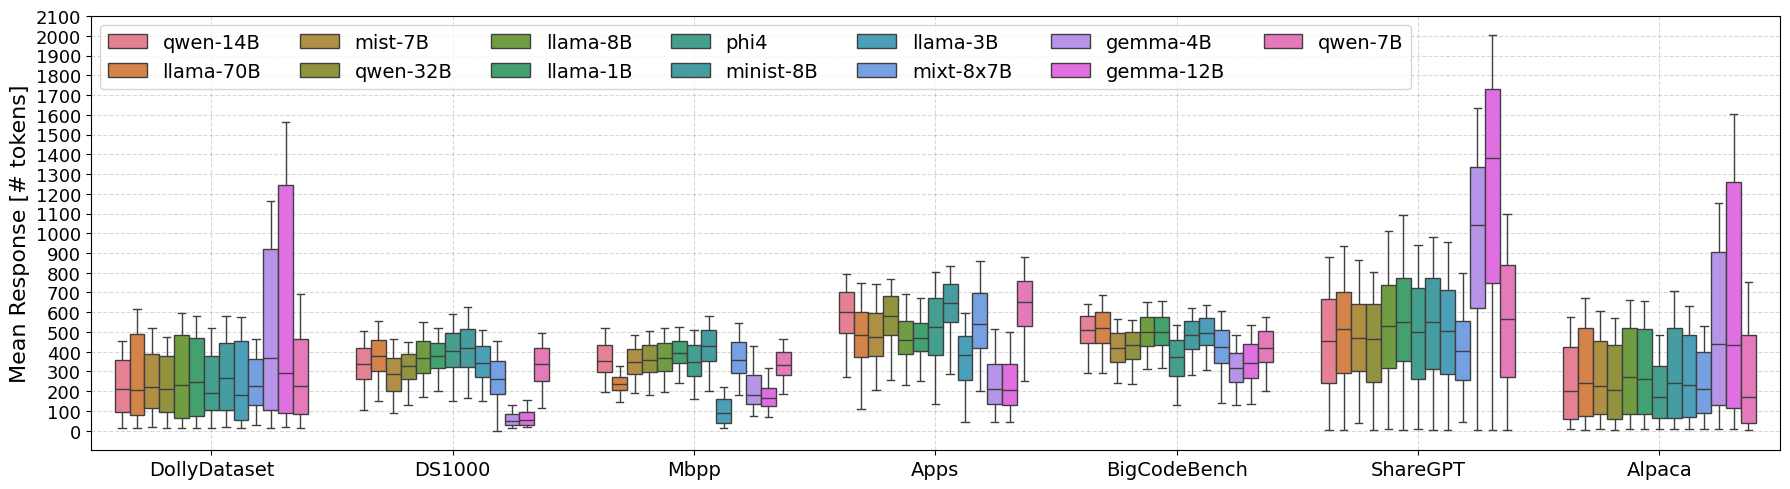

In [10]:
def plot_boxplot_mean_response_lengths(df, figsize=(12, 6), xtick_fontsize=10, xtick_rotation=0, flyers=False, whis=None, log=False, ytick_step=100):
    """
    Box plot of output_mean by model, grouped by dataset.

    Args:
        df (pd.DataFrame): Input DataFrame
        figsize (tuple): Figure size
        xtick_fontsize (int): Font size for xticks
        xtick_rotation (int): Rotation angle for xticks
        flyers (bool): Whether to show outliers
        whis (float or str): Whisker length, e.g., 1.5 or "range"
        log (bool): Whether to use log scale for y-axis

    Returns:
        matplotlib.figure.Figure: The resulting figure
    """
    # # Explode output_sizes to get one row per length
    # exploded_df = df.explode("output_sizes")

    # # Ensure output_sizes are integers
    # exploded_df["output_sizes"] = exploded_df["output_sizes"].astype(int)
    
    tmp_font_step = 2
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(data=df, x="dataset", y="output_mean", hue="model", ax=ax, showfliers=flyers, whis=whis)

    #ax.set_title("Boxplot of Mean Response Lengths by Model and Dataset")
    # ax.set_xlabel("Model", fontsize=xtick_fontsize+tmp_font_step)
    ax.set_xlabel(None)
    ax.set_ylabel("Mean Response [# tokens]", fontsize=xtick_fontsize+tmp_font_step)
    if log:
        ax.set_yscale("log")
    
    max_y = ax.get_ylim()[1]
    ax.set_yticks(np.arange(0, max_y, ytick_step))

    ax.tick_params(axis='x', labelsize=xtick_fontsize, rotation=xtick_rotation)
    ax.tick_params(axis='y', labelsize=xtick_fontsize-1)
    
    ax.grid(True, linestyle='--', color='gray', alpha=0.3)
    ax.legend(ncols=7, fontsize=xtick_fontsize)
    plt.tight_layout()
    return fig

fig = plot_boxplot_mean_response_lengths(df, figsize=(18, 5), xtick_fontsize=14, xtick_rotation=0, whis=(1, 90), ytick_step=100)

In [11]:
fig.savefig(f"{DST_SAVE_PATH}/sanitized_boxplot_mean_response_length.pdf", dpi=300, bbox_inches='tight')

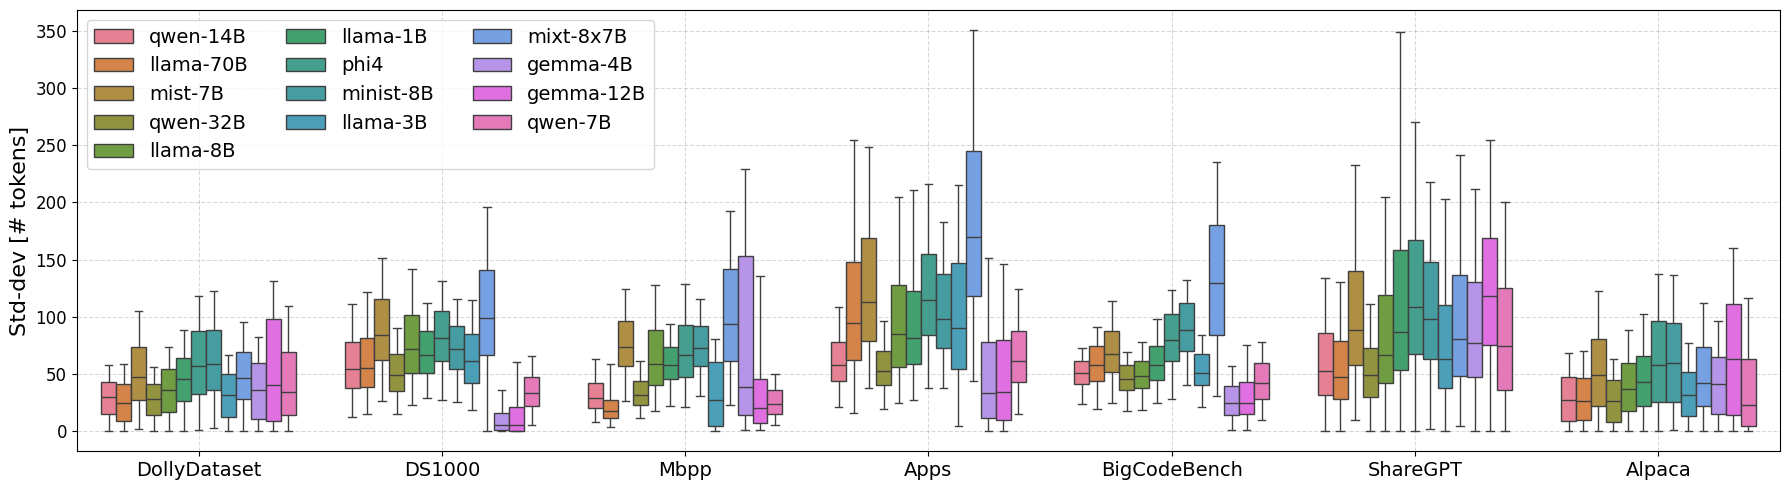

In [14]:
def plot_boxplot_stddev_response_lengths(df, figsize=(12, 6), xtick_fontsize=10, xtick_rotation=0, flyers=False, whis=None, log=False, ytick_step=100):
    """
    Box plot of output_mean by model, grouped by dataset.

    Args:
        df (pd.DataFrame): Input DataFrame
        figsize (tuple): Figure size
        xtick_fontsize (int): Font size for xticks
        xtick_rotation (int): Rotation angle for xticks
        flyers (bool): Whether to show outliers
        whis (float or str): Whisker length, e.g., 1.5 or "range"
        log (bool): Whether to use log scale for y-axis

    Returns:
        matplotlib.figure.Figure: The resulting figure
    """
    # # Explode output_sizes to get one row per length
    # exploded_df = df.explode("output_sizes")

    # # Ensure output_sizes are integers
    # exploded_df["output_sizes"] = exploded_df["output_sizes"].astype(int)
    
    tmp_font_step = 2
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(data=df, x="dataset", y="output_std", hue="model", ax=ax, showfliers=flyers, whis=whis)

    #ax.set_title("Boxplot of Mean Response Lengths by Model and Dataset")
    # ax.set_xlabel("Model", fontsize=xtick_fontsize+tmp_font_step)
    ax.set_xlabel(None)
    ax.set_ylabel("Std-dev [# tokens]", fontsize=xtick_fontsize+tmp_font_step)
    if log:
        ax.set_yscale("log")
    
    max_y = ax.get_ylim()[1]
    ax.set_yticks(np.arange(0, max_y, ytick_step))

    ax.tick_params(axis='x', labelsize=xtick_fontsize, rotation=xtick_rotation)
    ax.tick_params(axis='y', labelsize=xtick_fontsize-2)
    
    ax.grid(True, linestyle='--', color='gray', alpha=0.3)
    ax.legend(ncols=3, fontsize=xtick_fontsize)
    plt.tight_layout()
    return fig
fig = plot_boxplot_stddev_response_lengths(df, figsize=(18, 5), xtick_fontsize=14, xtick_rotation=0, whis=(1, 90), ytick_step=50)

In [15]:
fig.savefig(f"{DST_SAVE_PATH}/sanitized_boxplot_std_response_length.pdf", dpi=300, bbox_inches='tight')


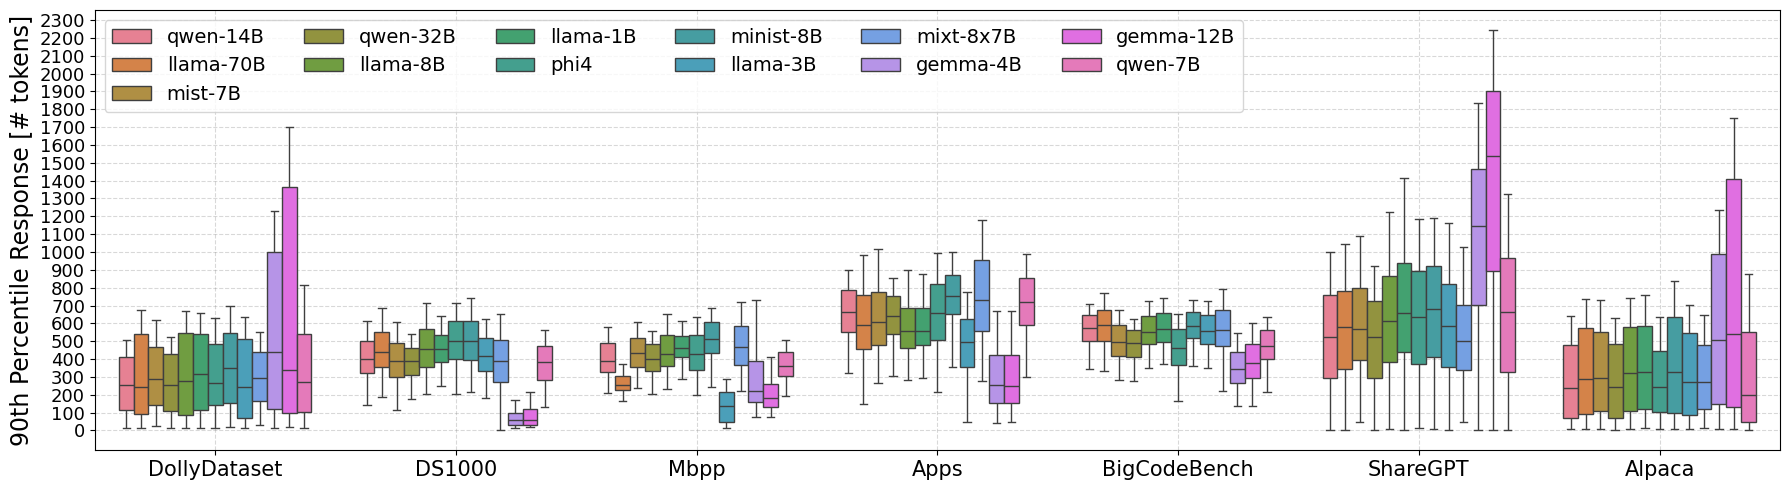

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_boxplot_response_percentile(df, percentile=90, figsize=(12, 6), xtick_fontsize=10, xtick_rotation=0,
                                     flyers=False, whis=None, log=False, ytick_step=100):
    """
    Box plot of per-row percentile response lengths, grouped by dataset and model.

    Args:
        df (pd.DataFrame): Input DataFrame with 'output_sizes' as list of ints per row
        percentile (int): Percentile to compute (e.g. 90)
        figsize (tuple): Figure size
        xtick_fontsize (int): Font size for xticks
        xtick_rotation (int): Rotation angle for xticks
        flyers (bool): Whether to show outliers
        whis (float or str): Whisker length, e.g., 1.5 or "range"
        log (bool): Whether to use log scale for y-axis
        ytick_step (int): Step size for y-ticks

    Returns:
        matplotlib.figure.Figure: The resulting figure
    """
    assert "output_sizes" in df.columns, "DataFrame must contain 'output_sizes' as list per row"
    
    # Compute per-row percentile and store in new column
    col_name = f"output_p{percentile}"
    df = df.copy()  # avoid modifying original
    df[col_name] = df["output_sizes"].apply(lambda sizes: np.percentile(sizes, percentile) if sizes else np.nan)

    tmp_font_step = 2
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.boxplot(data=df, x="dataset", y=col_name, hue="model", ax=ax,
                showfliers=flyers, whis=whis)

    ax.set_xlabel(None)
    ax.set_ylabel(f"{percentile}th Percentile Response [# tokens]", fontsize=xtick_fontsize + tmp_font_step)
    
    if log:
        ax.set_yscale("log")

    max_y = ax.get_ylim()[1]
    ax.set_yticks(np.arange(0, max_y, ytick_step))

    ax.tick_params(axis='x', labelsize=xtick_fontsize, rotation=xtick_rotation)
    ax.tick_params(axis='y', labelsize=xtick_fontsize-2)
    
    ax.grid(True, linestyle='--', color='gray', alpha=0.3)
    ax.legend(ncols=6, fontsize=xtick_fontsize - 1)
    plt.tight_layout()
    
    return fig
    
fig = plot_boxplot_response_percentile(df, percentile=90, figsize=(18, 5), xtick_fontsize=15,
                                       xtick_rotation=0, whis=(1, 90), ytick_step=100)

In [52]:
def plot_response_length_heatmap(df, figsize=(10, 8), xtick_fontsize=10, xtick_rotation=45, aggfunc="mean"):
    """
    Figure 3: Heatmap of aggregated output length statistics (mean or std) across model-dataset pairs.

    Args:
        df (pd.DataFrame): Input DataFrame with 'model', 'dataset', and output stats
        figsize (tuple): Figure size
        xtick_fontsize (int): Font size for xticks
        xtick_rotation (int): Rotation angle for xticks
        aggfunc (str): Aggregation function ('mean' or 'std')

    Returns:
        matplotlib.figure.Figure: The resulting figure
    """
    tmp_font_step = 2
    assert aggfunc in ['mean', 'std'], "aggfunc must be 'mean' or 'std'"
    value_col = "output_mean" if aggfunc == "mean" else "output_std"

    pivot_table = df.pivot_table(values=value_col, index="model", columns="dataset", aggfunc="mean")

    rename_dict = {
        "BigCodeBench": "BigCode",
        "DollyDataset": "Dolly",
    }
    pivot_table.rename(columns=rename_dict, inplace=True)
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt=".1f", ax=ax, linewidths=0.5, 
                linecolor='gray', 
                annot_kws={"size": xtick_fontsize+2}, 
                cbar_kws={'pad': 0.01} # 'shrink': 0.8,
               )
    #ax.set_title(f"Response Length {aggfunc.capitalize()}s per Model and Dataset")
    ax.tick_params(axis='x', labelsize=xtick_fontsize, rotation=xtick_rotation)
    ax.tick_params(axis='y', labelsize=xtick_fontsize)
    
    # ax.set_xlabel("Dataset", fontsize=xtick_fontsize+tmp_font_step)
    ax.set_xlabel(None)
    # ax.set_ylabel("Model", fontsize=xtick_fontsize+tmp_font_step)
    ax.set_ylabel(None)
    
    ax.grid(False)

    plt.tight_layout()
    return fig
    


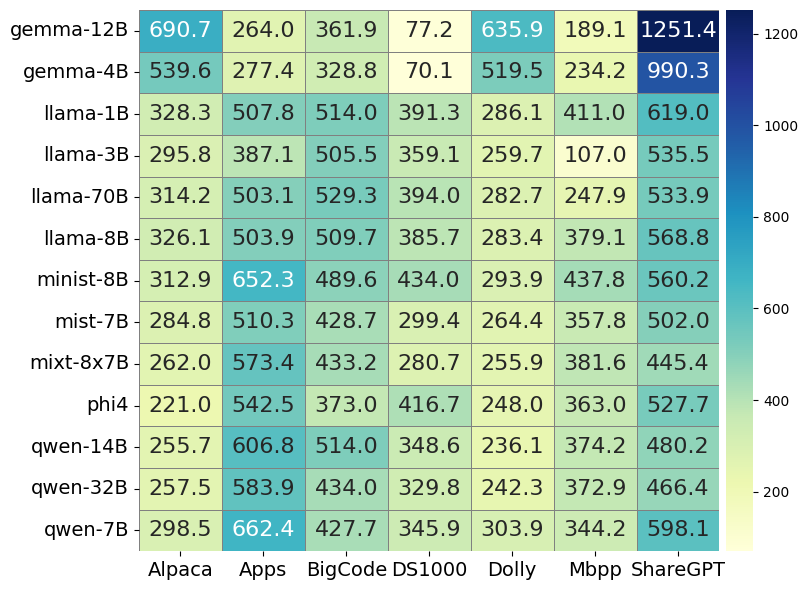

In [54]:
fig = plot_response_length_heatmap(df, aggfunc="mean", figsize=(8.5, 6), xtick_fontsize=14, xtick_rotation=0)

In [55]:
fig.savefig(f"{DST_SAVE_PATH}/sanitized_heatmap_mean_response_length.pdf", dpi=300, bbox_inches='tight')

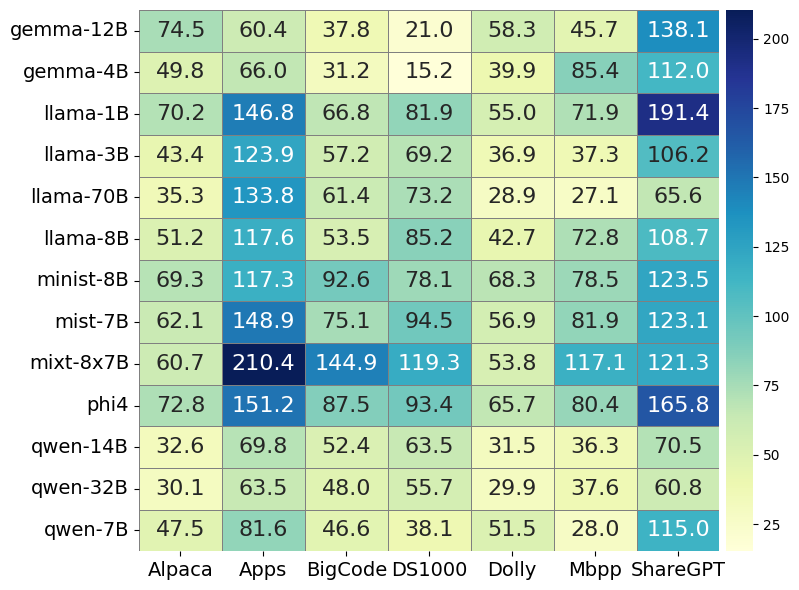

In [56]:
fig = plot_response_length_heatmap(df, aggfunc="std", figsize=(8.5, 6), xtick_fontsize=14, xtick_rotation=0)

In [57]:
fig.savefig(f"{DST_SAVE_PATH}/sanitized_heatmap_std_response_length.pdf", dpi=300, bbox_inches='tight')

In [14]:
def plot_sampled_prompt_variability_by_model(
    df,
    dataset_name,
    seed=42,
    N=10,
    K=5,
    figsize=(7, 4),
    xtick_fontsize=10,
    xtick_rotation=0, ytick_step = 100,
):
    np.random.seed(seed)
    
    # Filter by dataset
    df_subset = df[df["dataset"] == dataset_name]

    # Sample N unique prompt_ids
    sampled_prompt_ids = df_subset["prompt_id"].drop_duplicates().sample(n=N, random_state=seed)

    # Filter to only include those prompt_ids
    df_sampled = df_subset[df_subset["prompt_id"].isin(sampled_prompt_ids)]

    # Keep only models that have all N prompt_ids
    model_counts = df_sampled.groupby("model")["prompt_id"].nunique()
    valid_models = model_counts[model_counts == N].index.tolist()

    # Randomly select K from valid models
    if len(valid_models) == 0:
        raise ValueError(f"No models have all {N} sampled prompts in dataset '{dataset_name}'.")

    selected_models = np.random.choice(valid_models, size=min(K, len(valid_models)), replace=False)

    df_sampled = df_sampled[df_sampled["model"].isin(selected_models)]

    # Choose anchor model and order prompts
    anchor_model = np.random.choice(selected_models, 1)[0]
    anchor_df = df_sampled[df_sampled["model"] == anchor_model][["prompt_id", "output_mean"]]
    anchor_df_sorted = anchor_df.sort_values("output_mean")
    ordered_prompt_ids = anchor_df_sorted["prompt_id"].tolist()
    prompt_id_to_idx = {pid: idx for idx, pid in enumerate(ordered_prompt_ids)}

    # Begin plotting
    fig, ax = plt.subplots(figsize=figsize)

    y_values = []
    for model_name, group in df_sampled.groupby("model"):
        group = group.set_index("prompt_id").loc[ordered_prompt_ids].reset_index()
        x = group["prompt_id"].map(prompt_id_to_idx)
        y = group["output_mean"]
        yerr = group["output_std"]
        y_values.append(y.max())
        ax.plot(x, y, marker='o', label=model_name)
        ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)

    ax.set_title(f"Mean ± Std Response Lengths\n{K} Models, {N} Prompts from '{dataset_name}' (Sorted by {anchor_model})")
    ax.set_xlabel("Prompt Index (Sorted)")
    ax.set_ylabel("Response Length (tokens)")
    
    max_y = max(y_values)
    ax.set_yticks(np.arange(0, max_y + 2, ytick_step))
    
    ax.set_xticks(range(N))
    ax.set_xticklabels(range(N), fontsize=xtick_fontsize, rotation=xtick_rotation)
    ax.tick_params(axis='y', labelsize=xtick_fontsize)
    ax.grid(True, linestyle='--', color='gray', alpha=0.3)
    ax.legend(title="Model", fontsize=8)

    plt.tight_layout()
    return fig




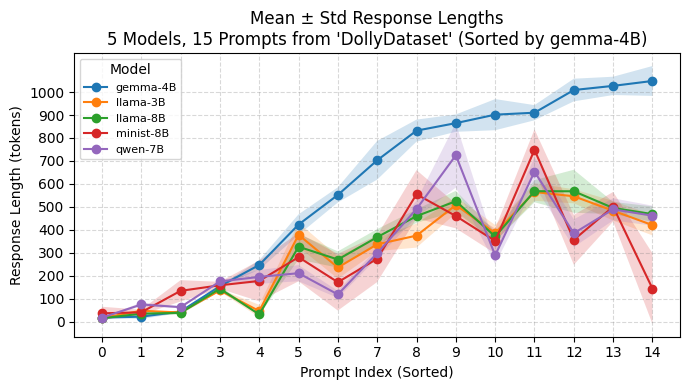

In [134]:
fig = plot_sampled_prompt_variability_by_model(df, figsize=(7, 4), dataset_name="DollyDataset", N=15, K=5, seed=3)
# 3

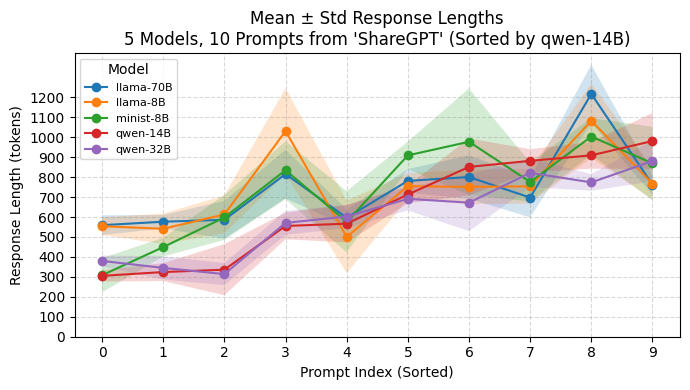

In [138]:
fig = plot_sampled_prompt_variability_by_model(df, dataset_name="ShareGPT", N=10, K=5, seed=4)
# 4, 12

In [ ]:
fig = plot_sampled_prompt_variability_by_model(df, dataset_name="ShareGPT", N=10, K=5, seed=4)
# 4, 12

In [144]:
def plot_sampled_prompt_variability_by_model(
    df,
    dataset_name,
    seed=42,
    N=10,
    K=5,
    ax=None,
    xtick_fontsize=10,
    xtick_rotation=0,
    ytick_step=100, idx = 0
):
    np.random.seed(seed)
    
    df_subset = df[df["dataset"] == dataset_name]
    sampled_prompt_ids = df_subset["prompt_id"].drop_duplicates().sample(n=N, random_state=seed)
    df_sampled = df_subset[df_subset["prompt_id"].isin(sampled_prompt_ids)]

    model_counts = df_sampled.groupby("model")["prompt_id"].nunique()
    valid_models = model_counts[model_counts == N].index.tolist()

    if len(valid_models) == 0:
        raise ValueError(f"No models have all {N} prompts in dataset '{dataset_name}'.")

    selected_models = np.random.choice(valid_models, size=min(K, len(valid_models)), replace=False)
    df_sampled = df_sampled[df_sampled["model"].isin(selected_models)]

    anchor_model = np.random.choice(selected_models, 1)[0]
    anchor_df = df_sampled[df_sampled["model"] == anchor_model][["prompt_id", "output_mean"]]
    ordered_prompt_ids = anchor_df.sort_values("output_mean")["prompt_id"].tolist()
    prompt_id_to_idx = {pid: idx for idx, pid in enumerate(ordered_prompt_ids)}

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))

    y_values = []
    for model_name, group in df_sampled.groupby("model"):
        group = group.set_index("prompt_id").loc[ordered_prompt_ids].reset_index()
        x = group["prompt_id"].map(prompt_id_to_idx)
        y = group["output_mean"]
        yerr = group["output_std"]
        y_values.append(y.max() + yerr.max())
        ax.plot(x, y, marker='o', label=model_name)
        ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)
    
    max_y = max(y_values)
    # ax.set_title(f"{dataset_name}")
    if dataset_name == "DollyDataset":
        dataset_name = "Dolly"
    ax.set_xlabel(f"Randomly selected prompt (p) from {dataset_name} dataset", fontsize=xtick_fontsize+2)
    if idx == 0: 
        ax.set_ylabel("Response Length [tokens]", fontsize=xtick_fontsize+2)
    ax.set_xticks(range(N))
    ax.set_xticklabels([f"p{i+1}" for i in range(N)], fontsize=xtick_fontsize, rotation=xtick_rotation)
    ax.tick_params(axis='y', labelsize=xtick_fontsize)
    ax.grid(True, linestyle='--', color='gray', alpha=0.3)

    return ax, max_y


def plot_prompt_variability_across_datasets(
    df,
    dataset_names,
    seeds,
    N=10,
    K=5,
    figsize_per_plot=(6, 4),
    xtick_fontsize=8,
    xtick_rotation=0,
    ytick_step=100
):
    num_datasets = len(dataset_names)
    if len(seeds) != num_datasets:
        raise ValueError("Number of seeds must match number of dataset names.")
    
    total_fig_width = figsize_per_plot[0] * num_datasets
    total_fig_height = figsize_per_plot[1]
    fig, axes = plt.subplots(1, num_datasets, figsize=(total_fig_width, total_fig_height), sharey=True)

    if num_datasets == 1:
        axes = [axes]

    y_max_vals = []
    for i, (dataset_name, seed) in enumerate(zip(dataset_names, seeds)):
        ax = axes[i]
        try:
            _, y_max_tmp = plot_sampled_prompt_variability_by_model(
                                    df=df,
                                    dataset_name=dataset_name,
                                    seed=seed,
                                    N=N,
                                    K=K,
                                    ax=ax,
                                    xtick_fontsize=xtick_fontsize,
                                    xtick_rotation=xtick_rotation,
                                    ytick_step=ytick_step, idx = i
                                )
            y_max_vals.append(y_max_tmp)
        except ValueError as ve:
            ax.set_title(f"{dataset_name}\n[Skipped: {ve}]")
            ax.axis("off")
    
    ax.set_yticks(np.arange(0, max(y_max_vals) + ytick_step, ytick_step))
    ax.set_yticklabels([str(int(elem))  if elem % 200 == 0 else "" for elem in np.arange(0, max(y_max_vals) + ytick_step, ytick_step)], fontsize=xtick_fontsize, rotation=xtick_rotation)
    
    handles, labels = axes[0].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='top right') #, ncol=len(labels), fontsize=8, title="Model")
    fig.legend(handles, labels, bbox_to_anchor=(0.20, 0.84), loc='center', ncol=2, fontsize=xtick_fontsize+1) #, title="Model")
    # fig.suptitle("Response Length Distribution Variability Across Datasets", fontsize=14)
    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.tight_layout()
    return fig



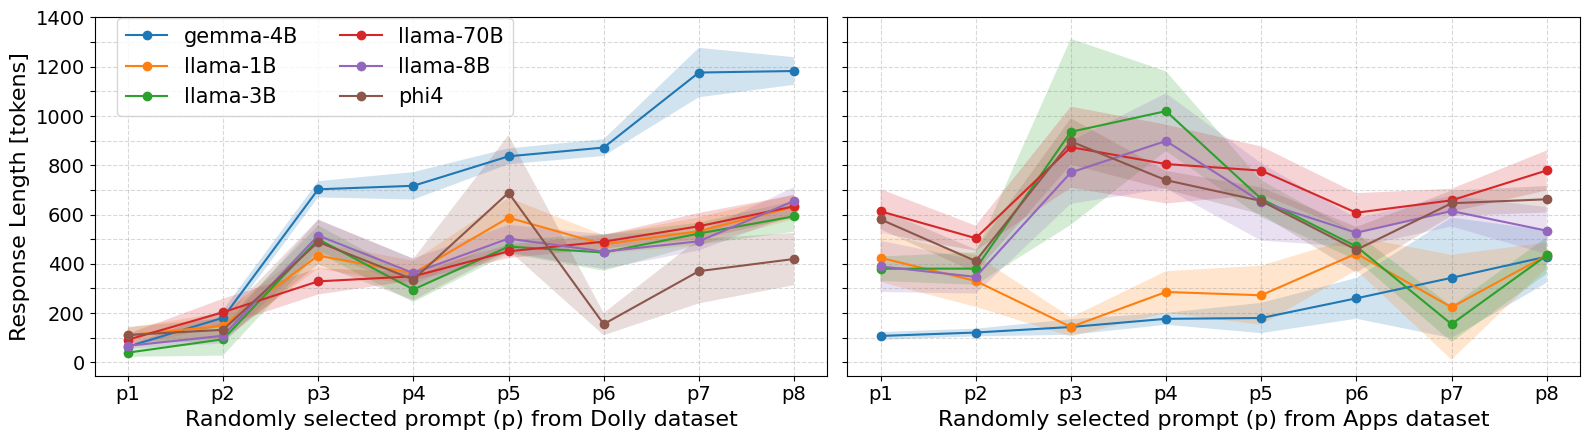

In [152]:
# dataset_names = ["DollyDataset", "ShareGPT", "Apps"]
# seeds = [81, 104, 18]
dataset_names = ["DollyDataset", "Apps"]
seeds = [81, 18]
# seeds = [81, 18]

fig = plot_prompt_variability_across_datasets(df, dataset_names, seeds, figsize_per_plot=(8, 4.5), N=8, K=6, ytick_step=100, xtick_fontsize=14)

In [153]:
fig.savefig(f"{DST_SAVE_PATH}/sanitized_lineplot_mean-std_per_sample.pdf", dpi=300, bbox_inches='tight')

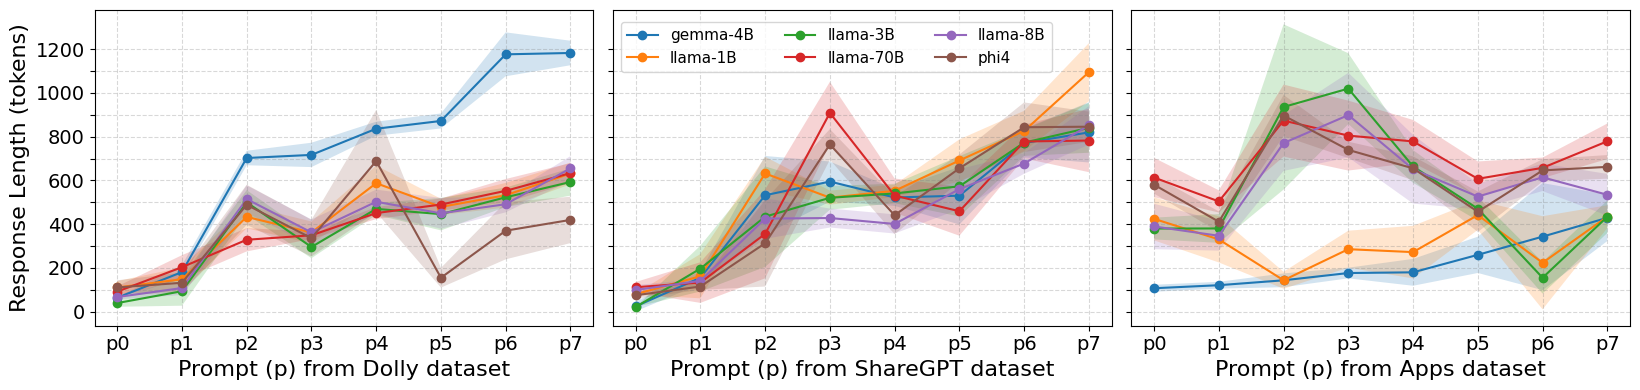

In [430]:
# dataset_names = ["DollyDataset", "ShareGPT", "Alpaca", "Apps"]
# seeds = [17, 26, 33, 8]
dataset_names = ["DollyDataset", "ShareGPT", "Apps"]
seeds = [81, 104, 18]


fig = plot_prompt_variability_across_datasets(df, dataset_names, seeds, figsize_per_plot=(5.5, 4), N=8, K=6, ytick_step=100, xtick_fontsize=14)

In [431]:
#fig.savefig(f"{DST_SAVE_PATH}/sanitized_lineplot_mean-std_per_sample.pdf", dpi=300, bbox_inches='tight')

In [14]:
# def plot_barplot_mean_or_std_with_error(
#     df,
#     value_type="mean",  # "mean" or "std"
#     exclude_models=None,
#     figsize=(12, 6),
#     xtick_fontsize=10,
#     xtick_rotation=0
# ):
#     """
#     Bar plot of output_mean or output_std per model-dataset combination with error bars (standard error of the mean).

#     Args:
#         df (pd.DataFrame): Input DataFrame with 'model', 'dataset', 'output_mean', 'output_std'
#         value_type (str): Either 'mean' to plot mean of output_mean or 'std' to plot mean of output_std
#         exclude_models (list): List of model names to exclude from the plot
#         figsize (tuple): Size of the figure
#         xtick_fontsize (int): Font size for x-axis ticks
#         xtick_rotation (int): Rotation angle for x-axis ticks

#     Returns:
#         matplotlib.figure.Figure: The resulting figure
#     """
#     assert value_type in ["mean", "std"], "value_type must be 'mean' or 'std'"
#     value_col = "output_mean" if value_type == "mean" else "output_std"

#     # Filter out excluded models
#     if exclude_models is not None:
#         df = df[~df["model"].isin(exclude_models)]

#     # Compute mean and standard error of the mean (SEM) per (model, dataset)
#     grouped = df.groupby(["model", "dataset"])[value_col].agg(['mean', 'sem']).reset_index()
#     grouped.rename(columns={'mean': 'mean_value', 'sem': 'sem_value'}, inplace=True)

#     # Create the bar plot
#     fig, ax = plt.subplots(figsize=figsize)
#     barplot = sns.barplot(
#         data=grouped,
#         x="model",
#         y="mean_value",
#         hue="dataset",
#         ax=ax,
#         errorbar=None,
#         capsize=0.1
#     )

#     # Add error bars manually using standard error
#     for i, bar in enumerate(ax.patches):
#         if i >= len(grouped):
#             break
#         row = grouped.iloc[i]
#         x = bar.get_x() + bar.get_width() / 2
#         height = bar.get_height()
#         err = row["sem_value"]
#         ax.errorbar(x, height, yerr=err, fmt='none', ecolor='black', capsize=3, linewidth=1)

#     ax.set_title(f"Mean {value_col} per Model and Dataset with SEM")
#     ax.set_xlabel("Model")
#     ax.set_ylabel(f"{value_col.capitalize()} (tokens)")
#     ax.tick_params(axis='x', labelsize=xtick_fontsize, rotation=xtick_rotation)
#     ax.grid(True, linestyle='--', color='gray', alpha=0.3)
#     ax.legend(title="Dataset")

#     plt.tight_layout()
#     return fig

# fig = plot_barplot_mean_or_std_with_error(
#     df, value_type="mean", exclude_models=["gemma-12B", "llama-70B"], figsize=(14, 6)
# )

In [180]:
def plot_std_to_mean_ratio_by_model_dataset(
    df,
    figsize=(12, 6),
    xtick_fontsize=10,
    xtick_rotation=0,
    log=False
):
    """
    Computes the ratio (as a percentage) of output_std to output_mean for each sample,
    and plots the average ratio per model and dataset with standard error bars.

    Args:
        df (pd.DataFrame): Input DataFrame with 'output_mean' and 'output_std'
        figsize (tuple): Size of the figure
        xtick_fontsize (int): Font size for x-axis ticks
        xtick_rotation (int): Rotation angle for x-axis ticks
        log (bool): Whether to use log scale on the y-axis

    Returns:
        matplotlib.figure.Figure: The resulting figure
    """
    # Avoid division by zero
    df_ratio = df[df["output_mean"] > 0].copy()

    # Compute percentage ratio of std to mean
    df_ratio["std_to_mean_pct"] = (df_ratio["output_std"] / df_ratio["output_mean"]) * 100

    # Compute mean and standard error per (model, dataset)
    grouped = df_ratio.groupby(["model", "dataset"])["std_to_mean_pct"].agg(['mean', 'sem']).reset_index()
    grouped.rename(columns={'mean': 'mean_ratio', 'sem': 'sem_ratio'}, inplace=True)

    # Create barplot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(
        data=grouped,
        x="model",
        y="mean_ratio",
        hue="dataset",
        ax=ax,
        errorbar=None,
        capsize=0.1, width=0.8
    )
    
    # Add custom error bars
    for i, bar in enumerate(ax.patches):
        if i >= len(grouped):
            break
        row = grouped.iloc[i]
        x = bar.get_x() + bar.get_width() / 2
        height = bar.get_height()
        err = row["sem_ratio"]
        ax.errorbar(x, height, yerr=err, fmt='none', ecolor='black', capsize=3, linewidth=1)
    tmp_step = 0
    # ax.set_title("Coefficient of Variation (as %)", fontsize = xtick_fontsize + tmp_step)
    #ax.set_xlabel("Model", fontsize = xtick_fontsize + tmp_step)
    ax.set_xlabel(None)
    ax.set_ylabel("Coeff. of Variation [%]", fontsize = xtick_fontsize + tmp_step)
    if log:
        ax.set_yscale("log")
    else:
        # Set yticks every 5%
        max_y = grouped["mean_ratio"].max() + grouped["sem_ratio"].max()
        ax.set_yticks(np.arange(0, max_y + 2, 5))

    ax.tick_params(axis='x', labelsize=xtick_fontsize-1, rotation=xtick_rotation)
    ax.tick_params(axis='y', labelsize=xtick_fontsize-1) 
    ax.grid(True, linestyle='--', color='gray', alpha=0.3)
    # ax.legend(title="Dataset", ncols=7)
    ax.legend(ncols=4, fontsize=xtick_fontsize-2, loc='upper left',  columnspacing=0.7)

    ax.set_xlim(ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5)
    plt.tight_layout()
    return fig


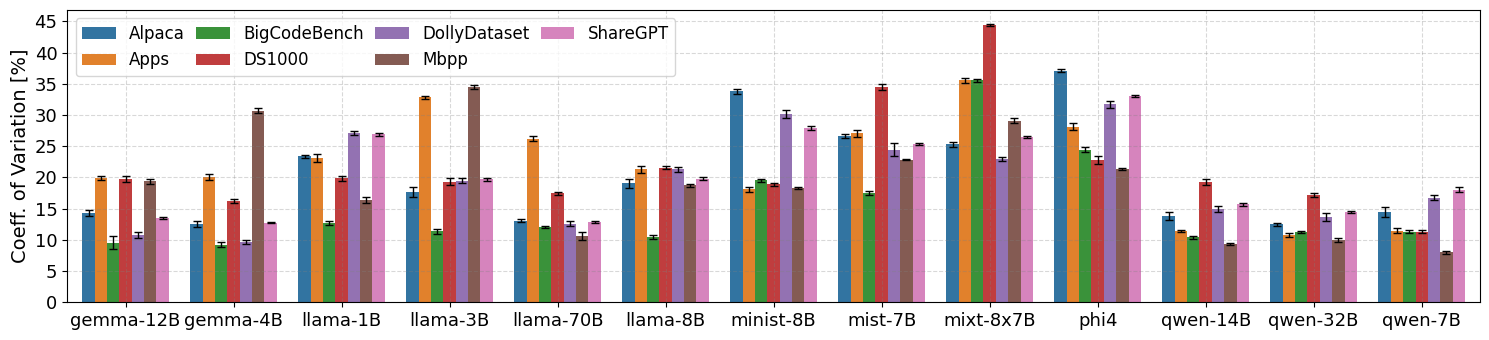

In [181]:
fig = plot_std_to_mean_ratio_by_model_dataset(df, figsize=(15, 3.5), xtick_rotation=0, xtick_fontsize=14)

In [182]:
fig.savefig(f"{DST_SAVE_PATH}/sanitized_barplot_coeff_of_variation.pdf", dpi=300, bbox_inches='tight')

In [183]:
def plot_feature_correlation_heatmap(
    df, method="kendall",
    figsize=(8, 6),
    annot=True,
    cmap="coolwarm",
    xtick_fontsize=10,
    ytick_fontsize=10
):
    """
    Plots a correlation heatmap between selected numerical features.

    Args:
        df (pd.DataFrame): Input DataFrame
        figsize (tuple): Figure size
        annot (bool): Whether to annotate the heatmap with correlation values
        cmap (str): Colormap for the heatmap
        xtick_fontsize (int): Font size for x-axis labels
        ytick_fontsize (int): Font size for y-axis labels

    Returns:
        matplotlib.figure.Figure: The resulting figure
    """
    # Select relevant numeric columns
    selected_columns = ["output_mean", "output_std", "temp", "input_size", "top_k", "top_p"]
    corr_df = df[selected_columns].dropna()

    # Compute correlation matrix
    corr_matrix = corr_df.corr(method=method)

    # Plot heatmap
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr_matrix, annot=annot, fmt=".2f", cmap=cmap, square=True, ax=ax, cbar=True,
                linewidths=0.5, linecolor='gray')

    ax.set_title("Feature Correlation Heatmap")
    ax.tick_params(axis='x', labelsize=xtick_fontsize, rotation=0)
    ax.tick_params(axis='y', labelsize=ytick_fontsize)

    plt.tight_layout()
    return fig

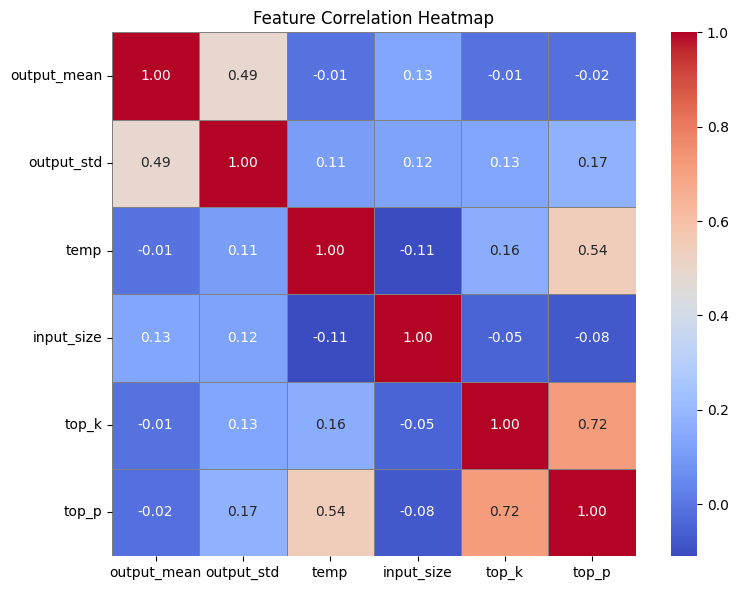

In [185]:
fig = plot_feature_correlation_heatmap(df, method="kendall")

In [192]:
def plot_upper_triangle_correlation_heatmap(
    df, method="kendall",
    figsize=(8, 6), rotation=20,
    annot=True,
    cmap="coolwarm",
    xtick_fontsize=10,
    ytick_fontsize=10
):
    """
    Plots an upper triangle correlation heatmap between selected numerical features.

    Args:
        df (pd.DataFrame): Input DataFrame
        figsize (tuple): Figure size
        annot (bool): Whether to annotate the heatmap with correlation values
        cmap (str): Colormap for the heatmap
        xtick_fontsize (int): Font size for x-axis labels
        ytick_fontsize (int): Font size for y-axis labels

    Returns:
        matplotlib.figure.Figure: The resulting figure
    """
    # Select relevant numeric columns
    selected_columns = ["input_size", "output_mean", "output_std", "temp", "top_k", "top_p"]
    corr_df = df[selected_columns].dropna()

    # Compute correlation matrix
    corr_matrix = corr_df.corr(method=method)

    # Mask the lower triangle
    mask = np.tril(np.ones_like(corr_matrix, dtype=bool), -1)

    # Plot heatmap
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr_matrix, mask=mask, annot=annot, fmt=".2f", cmap=cmap, ax=ax,
                cbar=True, linewidths=0.5, linecolor='gray',
                annot_kws={"size": xtick_fontsize+2}, 
                cbar_kws={'pad': 0.01}) # 'shrink': 0.8,)

    ax.set_title("Feature Correlation Heatmap (Upper Triangle)")
    ax.tick_params(axis='x', labelsize=xtick_fontsize, rotation=rotation)
    ax.tick_params(axis='y', labelsize=ytick_fontsize)
    
    plt.tight_layout()
    return fig


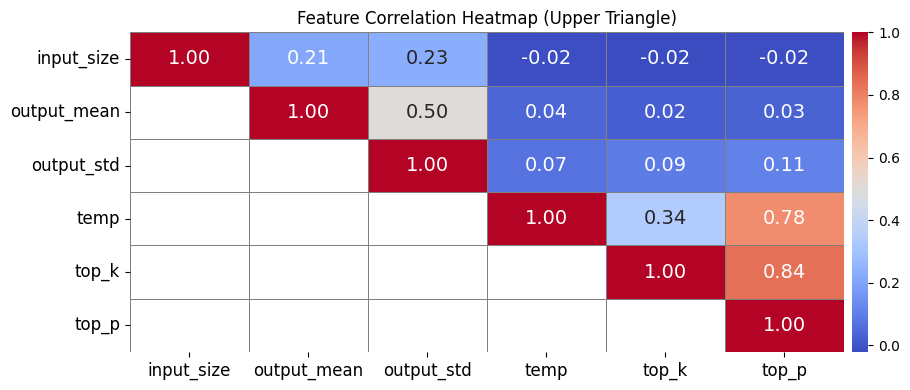

In [195]:
fig = plot_upper_triangle_correlation_heatmap(df, method="pearson", figsize=(10, 4), rotation=0, xtick_fontsize=12, ytick_fontsize=12)
plt.show()

In [112]:
def encode_categorical_and_plot_correlation(
    df,
    categorical_columns=["model", "dataset"],
    numerical_column="output_mean",
    figsize=(10, 5),
    cmap="coolwarm"
):
    """
    Encodes categorical variables as integers and computes correlation with a numerical column.
    Displays a heatmap with readable labels for the encoded categories.

    Args:
        df (pd.DataFrame): Input DataFrame
        categorical_columns (list): List of categorical columns to encode
        numerical_column (str): Numerical column to compute correlation with
        figsize (tuple): Size of the figure
        cmap (str): Colormap to use for the heatmap

    Returns:
        matplotlib.figure.Figure: The resulting heatmap figure
    """
    from sklearn.preprocessing import LabelEncoder

    encoded_df = df.copy()
    label_maps = {}

    # Encode categorical variables
    for col in categorical_columns:
        le = LabelEncoder()
        encoded_df[col + "_encoded"] = le.fit_transform(encoded_df[col])
        label_maps[col] = dict(zip(le.transform(le.classes_), le.classes_))

    # Select relevant columns for correlation
    corr_columns = [col + "_encoded" for col in categorical_columns] + [numerical_column]
    corr_matrix = encoded_df[corr_columns].corr()

    # Rename rows and columns for better readability
    rename_map = {col + "_encoded": col for col in categorical_columns}
    corr_matrix.rename(index=rename_map, columns=rename_map, inplace=True)

    # Plot heatmap
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr_matrix[[numerical_column]].drop(numerical_column), annot=True, fmt=".2f",
                cmap=cmap, cbar=True, linewidths=0.5, linecolor='gray', ax=ax)

    ax.set_title(f"Correlation of Encoded Categorical Variables with '{numerical_column}'")
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

    plt.tight_layout()
    return fig, label_maps



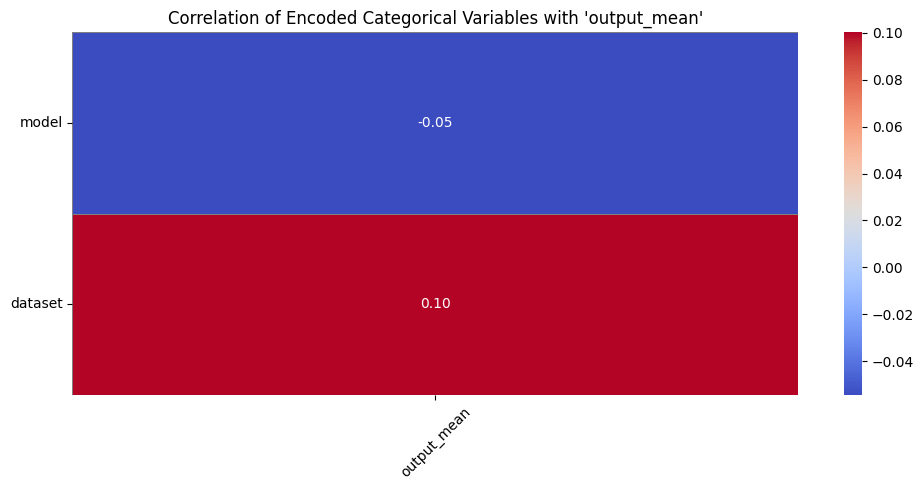

In [113]:
fig = encode_categorical_and_plot_correlation(df)

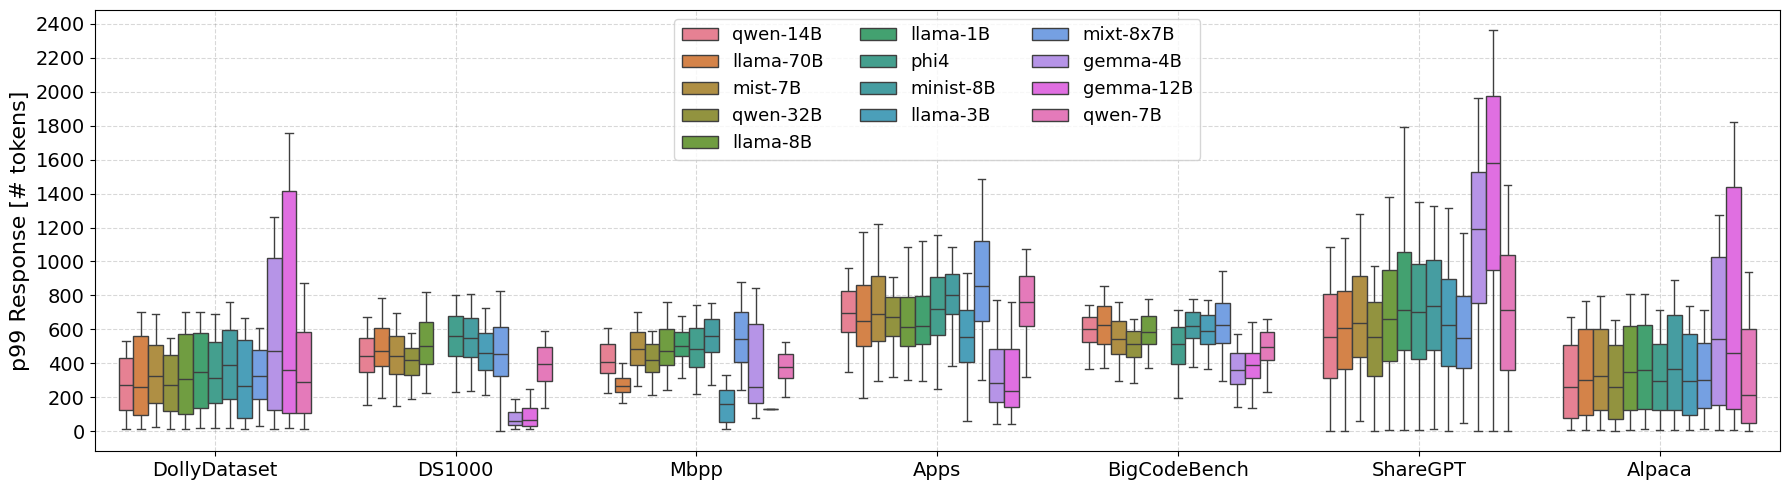

In [20]:
def plot_boxplot_p99_response_lengths(df, figsize=(12, 6), xtick_fontsize=10, xtick_rotation=0, flyers=False, whis=None, log=False, ytick_step=100):
    """
    Box plot of p99 response lengths by dataset, grouped by model.
    """
    tmp_font_step = 2

    # Extract p99
    df = df.copy()
    df["p99"] = df["output_percentiles"].apply(lambda d: d.get("p99", None))
    df = df[df["p99"].notnull()]

    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(
        data=df,
        x="dataset",
        y="p99",
        hue="model",
        ax=ax,
        showfliers=flyers,
        whis=whis
    )

    ax.set_xlabel(None)
    ax.set_ylabel("p99 Response [# tokens]", fontsize=xtick_fontsize + tmp_font_step)

    if log:
        ax.set_yscale("log")

    max_y = ax.get_ylim()[1]
    ax.set_yticks(np.arange(0, max_y, ytick_step))

    ax.tick_params(axis='x', labelsize=xtick_fontsize, rotation=xtick_rotation)
    ax.tick_params(axis='y', labelsize=xtick_fontsize)
    ax.grid(True, linestyle='--', color='gray', alpha=0.3)
    ax.legend(ncols=3, fontsize=xtick_fontsize - 1)

    plt.tight_layout()
    return fig


fig = plot_boxplot_p99_response_lengths(df, figsize=(18, 5), xtick_fontsize=14, xtick_rotation=0, whis=(1, 90), ytick_step=200)


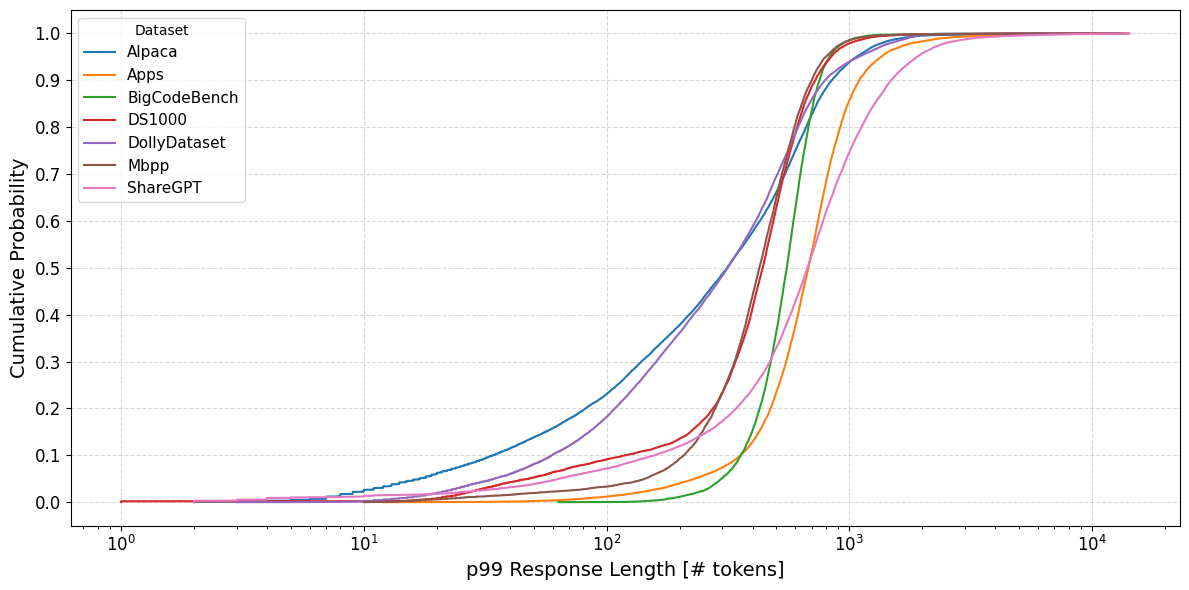

In [22]:
def plot_cdf_p99_response_lengths(
    df,
    figsize=(12, 6),
    xtick_fontsize=10,
    xtick_rotation=0,
    log=False,
    ytick_step=0.1,
    show_legend=True
):
    """
    Returns:
        matplotlib.figure.Figure: The resulting figure
    """
    import matplotlib.pyplot as plt
    import numpy as np

    tmp_font_step = 2

    # Extract and clean p99 values
    df = df.copy()
    df["p99"] = df["output_percentiles"].apply(lambda d: d.get("p99", None))
    df = df[df["p99"].notnull()]

    fig, ax = plt.subplots(figsize=figsize)

    # Plot CDF for each dataset
    for dataset_name, group in df.groupby("dataset"):
        values = np.sort(group["p99"].values)
        cdf = np.arange(1, len(values) + 1) / len(values)
        ax.plot(values, cdf, label=dataset_name)

    ax.set_xlabel("p99 Response Length [# tokens]", fontsize=xtick_fontsize + tmp_font_step)
    ax.set_ylabel("Cumulative Probability", fontsize=xtick_fontsize + tmp_font_step)

    if log:
        ax.set_xscale("log")

    ax.set_yticks(np.arange(0, 1.01, ytick_step))
    ax.tick_params(axis='x', labelsize=xtick_fontsize, rotation=xtick_rotation)
    ax.tick_params(axis='y', labelsize=xtick_fontsize)
    ax.grid(True, linestyle='--', color='gray', alpha=0.3)

    if show_legend:
        ax.legend(title="Dataset", fontsize=xtick_fontsize - 1)

    plt.tight_layout()
    return fig


fig = plot_cdf_p99_response_lengths(
    df,
    figsize=(12, 6),
    xtick_fontsize=12,
    xtick_rotation=0,
    ytick_step=0.1,
    log=True
)

# CLAUDE

In [81]:
def set_plot_style():
    """Set default style for matplotlib plots"""
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_theme(style="whitegrid")
    # Set color palette
    colors = sns.color_palette("viridis", 20)
    sns.set_palette(colors)

In [2]:
def boxplot_by_model_dataset(df, figsize=(14, 10), fontsize=10, rotation=45, grid=True, flyers=False):
    """
    Create box plots showing response length distributions by model, grouped by dataset.
    
    Args:
        df: DataFrame containing the LLM response data
        figsize: Tuple specifying figure dimensions (width, height)
        fontsize: Font size for x-tick labels
        rotation: Rotation angle for x-tick labels
        grid: Boolean indicating whether to show grid lines
    
    Returns:
        matplotlib figure
    """
    # set_plot_style()
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create box plot of response lengths by model, hue by dataset
    sns.boxplot(
        data=df, 
        x='model', 
        y='output_mean', 
        hue='dataset', 
        ax=ax,
        fliersize=3, showfliers=flyers
    )
    
    # Customize plot appearance
    ax.set_title('Response Length Distribution by Model and Dataset', fontsize=fontsize+4)
    ax.set_xlabel('Model', fontsize=fontsize+2)
    ax.set_ylabel('Mean Response Length (tokens)', fontsize=fontsize+2)
    
    if grid:
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Customize tick labels
    plt.xticks(fontsize=fontsize, rotation=rotation)
    plt.yticks(fontsize=fontsize)
    
    # Adjust legend position
    plt.legend(title='Dataset', title_fontsize=fontsize, fontsize=fontsize-2, 
               loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    return fig

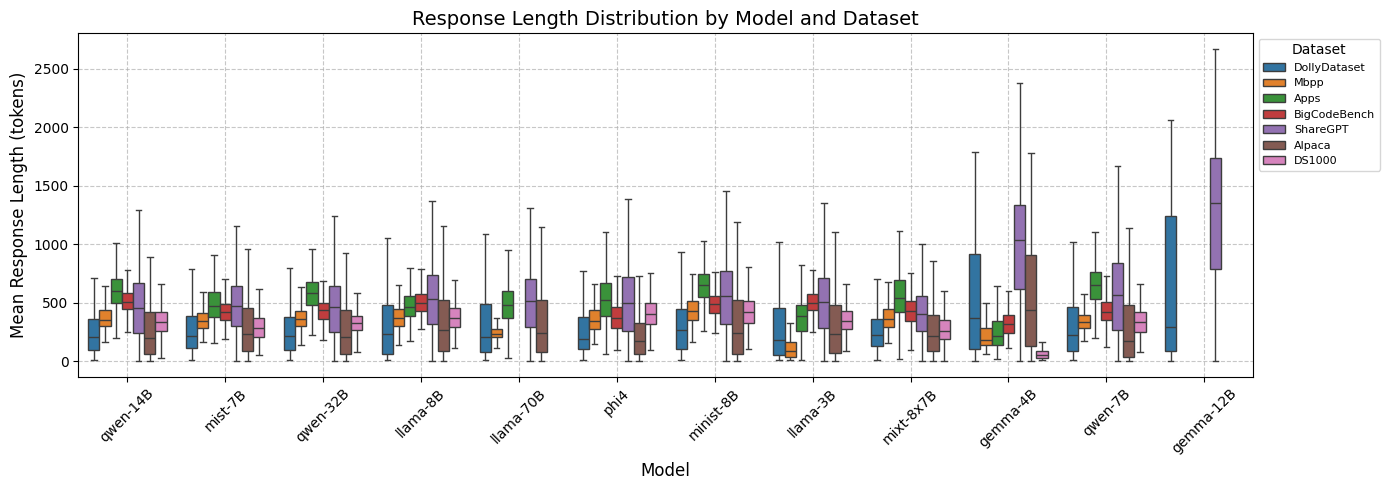

In [3]:
fig = boxplot_by_model_dataset(df, figsize=(14, 5), fontsize=10, rotation=45, grid=True)

In [4]:
def violin_plot_by_model(df, figsize=(14, 10), fontsize=10, rotation=45, grid=True):
    """
    Create violin plots showing distribution of output sizes across models.
    
    Args:
        df: DataFrame containing the LLM response data
        figsize: Tuple specifying figure dimensions (width, height)
        fontsize: Font size for x-tick labels
        rotation: Rotation angle for x-tick labels
        grid: Boolean indicating whether to show grid lines
    
    Returns:
        matplotlib figure
    """
    # set_plot_style()
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create violin plot
    sns.violinplot(
        data=df, 
        x='model', 
        y='output_mean', 
        hue='dataset',
        split=False,
        inner='quartile', 
        ax=ax
    )
    
    # Customize plot appearance
    ax.set_title('Response Length Distribution by Model', fontsize=fontsize+4)
    ax.set_xlabel('Model', fontsize=fontsize+2)
    ax.set_ylabel('Mean Response Length (tokens)', fontsize=fontsize+2)
    # ax.set_yscale("log")
    if grid:
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Customize tick labels
    plt.xticks(fontsize=fontsize, rotation=rotation)
    plt.yticks(fontsize=fontsize)
    
    # Adjust legend position
    plt.legend(title='Dataset', title_fontsize=fontsize, fontsize=fontsize-2, 
               loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    return fig

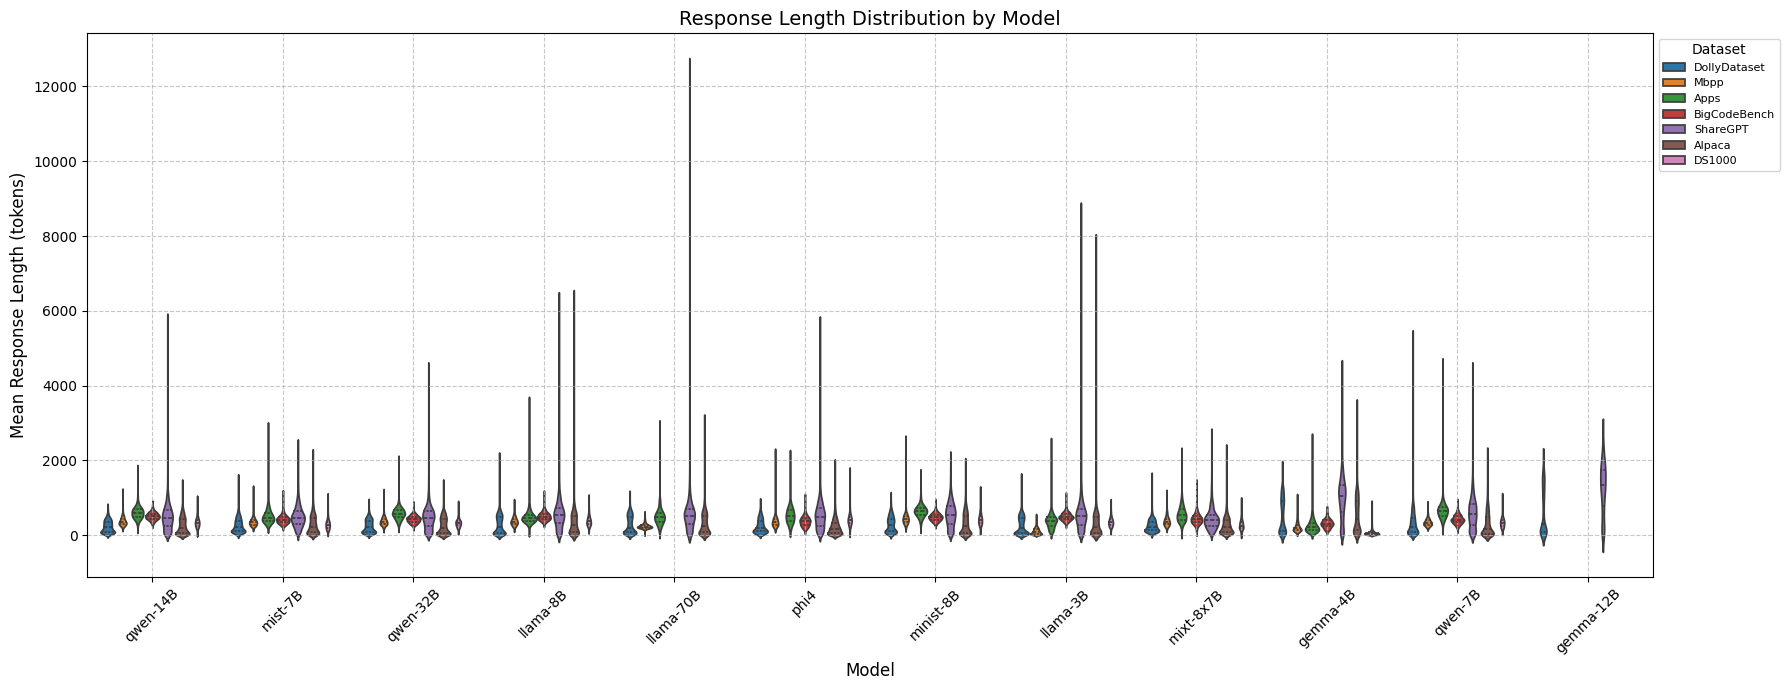

In [5]:
fig = violin_plot_by_model(df, figsize=(18, 7), fontsize=10, rotation=45, grid=True)

In [6]:
def heatmap_std_by_model_dataset(df, figsize=(12, 10), fontsize=10, rotation=45):
    """
    Create a heatmap showing standard deviation of response lengths across model-dataset combinations.
    
    Args:
        df: DataFrame containing the LLM response data
        figsize: Tuple specifying figure dimensions (width, height)
        fontsize: Font size for tick labels
        rotation: Rotation angle for tick labels
    
    Returns:
        matplotlib figure
    """
    # set_plot_style()
    
    # Create pivot table of standard deviations
    pivot_std = df.pivot_table(
        values='output_std', 
        index='dataset', 
        columns='model', 
        aggfunc='mean'
    )
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(
        pivot_std, 
        annot=True, 
        cmap='viridis', 
        fmt='.1f',
        linewidths=0.5,
        ax=ax
    )
    
    # Customize plot appearance
    ax.set_title('Standard Deviation of Response Lengths by Model and Dataset', fontsize=fontsize+4)
    ax.set_xlabel('Model', fontsize=fontsize+2)
    ax.set_ylabel('Dataset', fontsize=fontsize+2)
    
    # Customize tick labels
    plt.xticks(fontsize=fontsize, rotation=rotation)
    plt.yticks(fontsize=fontsize, rotation=0)
    
    plt.tight_layout()
    return fig


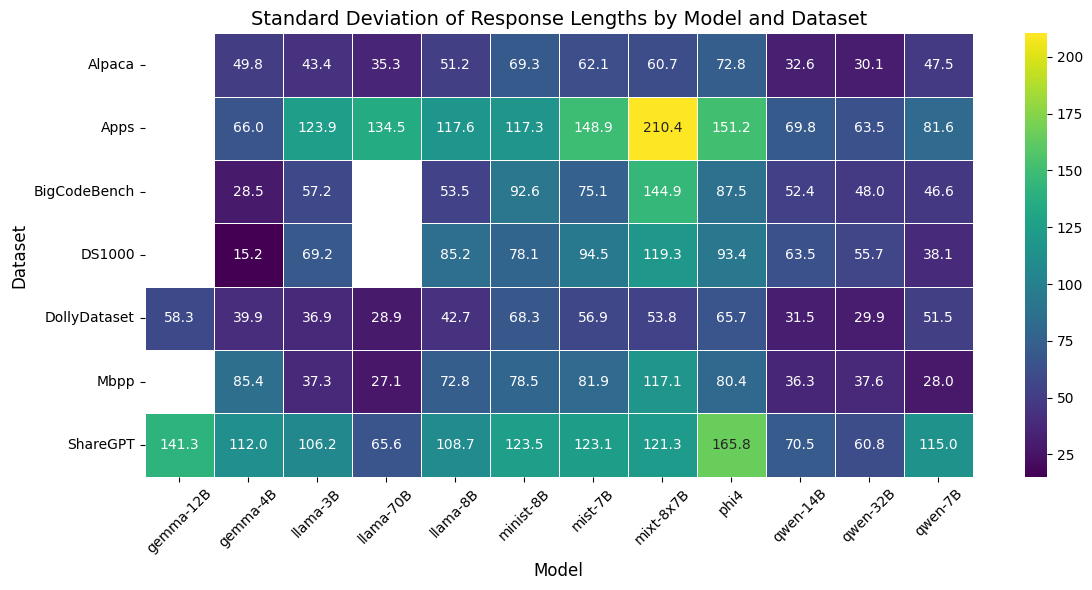

In [7]:
fig = heatmap_std_by_model_dataset(df, figsize=(12, 6), fontsize=10, rotation=45)

In [19]:
def heatmap_cv_by_model_dataset(df, figsize=(12, 10), fontsize=10, rotation=45):
    """
    Create a heatmap showing coefficient of variation (std/mean) of response lengths
    across model-dataset combinations.
    
    Args:
        df: DataFrame containing the LLM response data
        figsize: Tuple specifying figure dimensions (width, height)
        fontsize: Font size for tick labels
        rotation: Rotation angle for tick labels
    
    Returns:
        matplotlib figure
    """
    # set_plot_style()
    
    # Calculate coefficient of variation (CV)
    df_cv = df.copy()
    df_cv['cv'] = 100 * df['output_std'] / df['output_mean']
    
    # Create pivot table of CV values
    pivot_cv = df_cv.pivot_table(
        values='cv', 
        index='dataset', 
        columns='model', 
        aggfunc='mean'
    )
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(
        pivot_cv, 
        annot=True, 
        cmap='viridis', 
        fmt='.2f',
        linewidths=0.5,
        ax=ax
    )
    
    # Customize plot appearance
    ax.set_title('Coefficient of Variation (std-dev/mean) by Model and Dataset', fontsize=fontsize+4)
    ax.set_xlabel('Model', fontsize=fontsize+2)
    ax.set_ylabel('Dataset', fontsize=fontsize+2)
    
    # Customize tick labels
    plt.xticks(fontsize=fontsize, rotation=rotation)
    plt.yticks(fontsize=fontsize, rotation=0)
    
    plt.tight_layout()
    return fig

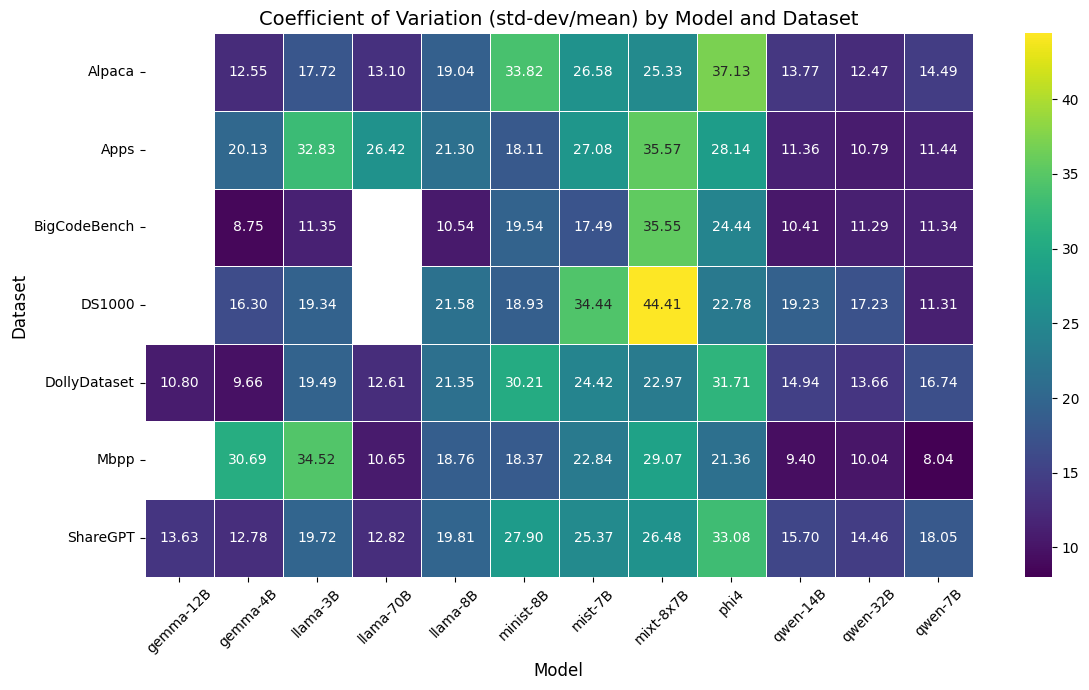

In [20]:
fig = heatmap_cv_by_model_dataset(df, figsize=(12, 7), fontsize=10, rotation=45)

In [21]:
def scatter_mean_std_by_model(df, figsize=(14, 10), fontsize=10, rotation=45, grid=True):
    """
    Create a scatter plot showing mean response length with standard deviation error bars by model.
    
    Args:
        df: DataFrame containing the LLM response data
        figsize: Tuple specifying figure dimensions (width, height)
        fontsize: Font size for x-tick labels
        rotation: Rotation angle for x-tick labels
        grid: Boolean indicating whether to show grid lines
    
    Returns:
        matplotlib figure
    """
    # set_plot_style()
    
    # Group data by model
    model_stats = df.groupby('model').agg({
        'output_mean': ['mean', 'std'],
        'output_std': 'mean'
    }).reset_index()
    
    # Flatten multi-level column names
    model_stats.columns = ['model', 'mean_of_means', 'std_of_means', 'mean_std']
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create scatter plot with error bars
    ax.errorbar(
        x=range(len(model_stats)), 
        y=model_stats['mean_of_means'],
        yerr=model_stats['mean_std'],
        fmt='o',
        capsize=5,
        markersize=8,
        elinewidth=2
    )
    
    # Customize plot appearance
    ax.set_title('Mean Response Length with Standard Deviation by Model', fontsize=fontsize+4)
    ax.set_xlabel('Model', fontsize=fontsize+2)
    ax.set_ylabel('Mean Response Length (tokens)', fontsize=fontsize+2)
    
    if grid:
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set x-ticks to model names
    ax.set_xticks(range(len(model_stats)))
    ax.set_xticklabels(model_stats['model'], fontsize=fontsize, rotation=rotation)
    
    plt.tight_layout()
    return fig

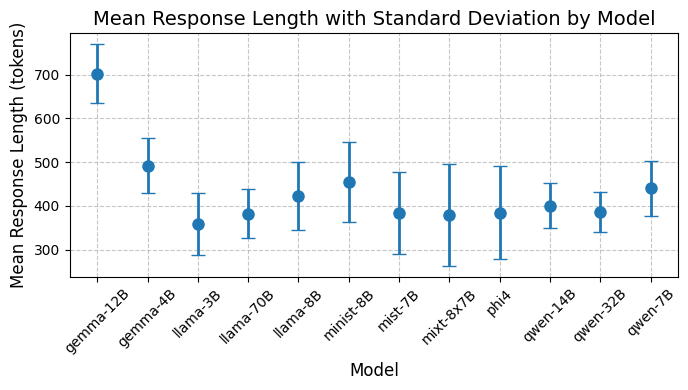

In [23]:
dig = scatter_mean_std_by_model(df, figsize=(7, 4), fontsize=10, rotation=45, grid=True)

In [24]:
def distribution_plot_by_size_category(df, figsize=(14, 10), fontsize=10, rotation=0, grid=True):
    """
    Create a distribution plot showing response length distributions categorized by size.
    
    Args:
        df: DataFrame containing the LLM response data
        figsize: Tuple specifying figure dimensions (width, height)
        fontsize: Font size for labels
        rotation: Rotation angle for x-tick labels
        grid: Boolean indicating whether to show grid lines
    
    Returns:
        matplotlib figure
    """
    # set_plot_style()
    
    # Add size category column
    df_size = df.copy()
    
    # Create size categories based on percentiles
    size_bins = [0, df['output_mean'].quantile(0.25), 
                df['output_mean'].quantile(0.5),
                df['output_mean'].quantile(0.75), 
                df['output_mean'].max()]
    
    size_labels = ['Small', 'Medium', 'Large', 'Extra Large']
    
    df_size['size_category'] = pd.cut(
        df_size['output_mean'], 
        bins=size_bins, 
        labels=size_labels
    )
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create distribution plot
    for category in size_labels:
        subset = df_size[df_size['size_category'] == category]
        sns.kdeplot(
            data=subset, 
            x='output_std',
            label=category,
            ax=ax,
            fill=True,
            alpha=0.3
        )
    
    # Customize plot appearance
    ax.set_title('Distribution of Standard Deviations by Response Size Category', fontsize=fontsize+4)
    ax.set_xlabel('Standard Deviation', fontsize=fontsize+2)
    ax.set_ylabel('Density', fontsize=fontsize+2)
    
    if grid:
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Customize tick labels
    plt.xticks(fontsize=fontsize, rotation=rotation)
    plt.yticks(fontsize=fontsize)
    
    plt.legend(title='Response Size', title_fontsize=fontsize, fontsize=fontsize-2)
    
    plt.tight_layout()
    return fig

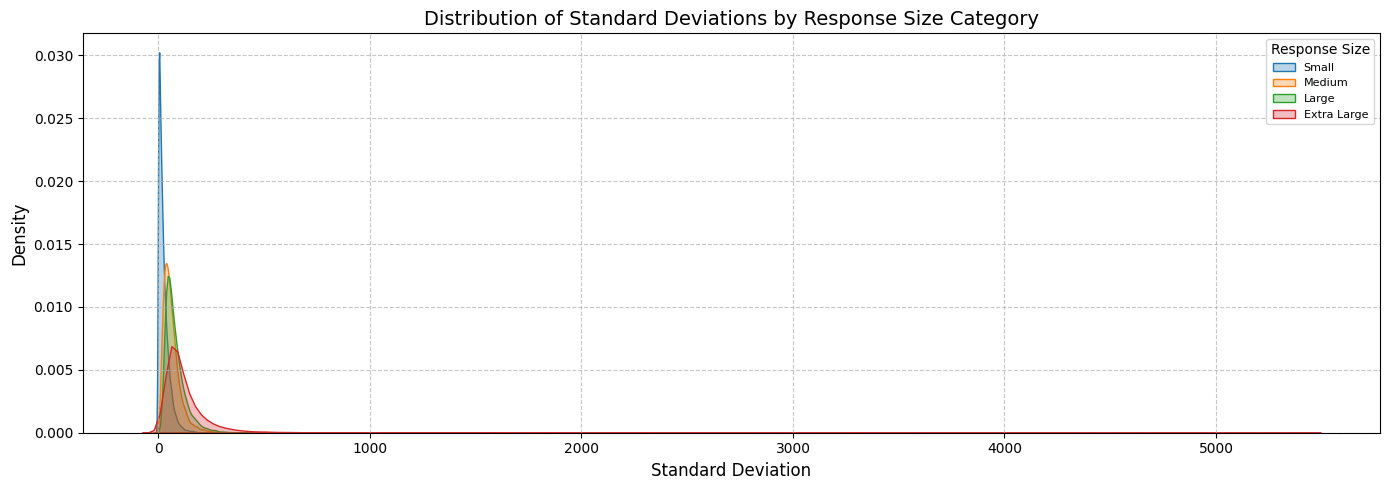

In [26]:
fig = distribution_plot_by_size_category(df, figsize=(14, 5), fontsize=10, rotation=0, grid=True)

In [38]:
def bar_percentile_by_model(df, figsize=(14, 10), fontsize=10, rotation=45, grid=True):
    """
    Create a bar plot showing percentile differences (99th - 25th) by model.
    
    Args:
        df: DataFrame containing the LLM response data
        figsize: Tuple specifying figure dimensions (width, height)
        fontsize: Font size for x-tick labels
        rotation: Rotation angle for x-tick labels
        grid: Boolean indicating whether to show grid lines
    
    Returns:
        matplotlib figure
    """
    # set_plot_style()
    
    # Extract percentiles
    df_percentiles = df.copy()
    
    # Example of extracting percentiles from the dictionary
    # Note: Adjust this according to the actual structure of your output_percentiles
    df_percentiles['p25'] = df_percentiles['output_percentiles'].apply(lambda x: x.get('p25', 0) if isinstance(x, dict) else 0)
    df_percentiles['p50'] = df_percentiles['output_percentiles'].apply(lambda x: x.get('p50', 0) if isinstance(x, dict) else 0)
    df_percentiles['p75'] = df_percentiles['output_percentiles'].apply(lambda x: x.get('p75', 0) if isinstance(x, dict) else 0)
    df_percentiles['p99'] = df_percentiles['output_percentiles'].apply(lambda x: x.get('p99', 0) if isinstance(x, dict) else 0)
    
    # Calculate percentile range
    df_percentiles['p99_p25_range'] = df_percentiles['p99'] - df_percentiles['p50']
    
    # Group by model
    model_ranges = df_percentiles.groupby('model')['p99_p25_range'].mean().sort_values(ascending=False).reset_index()
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create bar plot
    sns.barplot(
        data=model_ranges,
        x='model',
        y='p99_p25_range',
        ax=ax
    )
    
    # Customize plot appearance
    ax.set_title('Response Length Range (99th - 25th percentile) by Model', fontsize=fontsize+4)
    ax.set_xlabel('Model', fontsize=fontsize+2)
    ax.set_ylabel('Percentile Range (tokens)', fontsize=fontsize+2)
    
    if grid:
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Customize tick labels
    plt.xticks(fontsize=fontsize, rotation=rotation)
    plt.yticks(fontsize=fontsize)
    
    plt.tight_layout()
    return fig

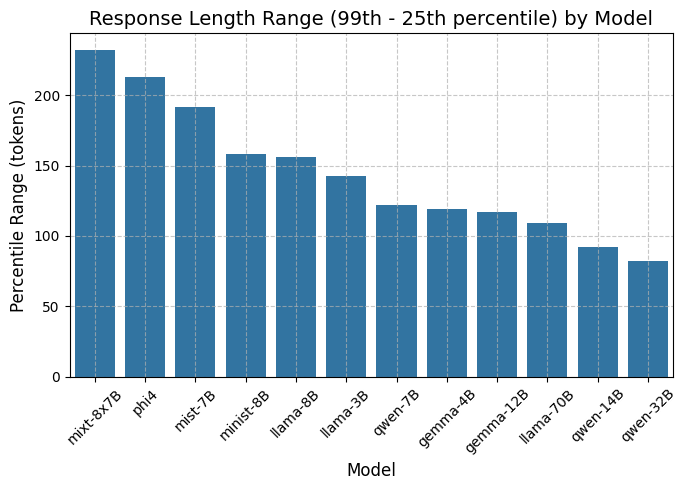

In [39]:
fig = bar_percentile_by_model(df, figsize=(7,5), fontsize=10, rotation=45, grid=True)

In [42]:
def model_stability_index(df, figsize=(14, 10), fontsize=10, rotation=45, grid=True):
    """
    Create a bar chart showing a "stability index" (inverse of CV) by model.
    
    Args:
        df: DataFrame containing the LLM response data
        figsize: Tuple specifying figure dimensions (width, height)
        fontsize: Font size for x-tick labels
        rotation: Rotation angle for x-tick labels
        grid: Boolean indicating whether to show grid lines
    
    Returns:
        matplotlib figure
    """
    # set_plot_style()
    
    # Calculate coefficient of variation (CV)
    df_stability = df.copy()
    df_stability['cv'] = df['output_std'] / df['output_mean']
    
    # Calculate stability index (inverse of CV)
    df_stability['stability_index'] = 1 / df_stability['cv']
    
    # Group by model and calculate mean stability index
    model_stability = df_stability.groupby('model')['stability_index'].mean().sort_values(ascending=False).reset_index()
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create bar plot
    sns.barplot(
        data=model_stability,
        x='model',
        y='stability_index',
        ax=ax
    )
    
    # Customize plot appearance
    ax.set_title('Response Length Stability Index by Model (higher = more stable)', fontsize=fontsize+4)
    ax.set_xlabel('Model', fontsize=fontsize+2)
    ax.set_ylabel('Stability Index (1/CV)', fontsize=fontsize+2)
    
    if grid:
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Customize tick labels
    plt.xticks(fontsize=fontsize, rotation=rotation)
    plt.yticks(fontsize=fontsize)
    
    plt.tight_layout()
    return fig


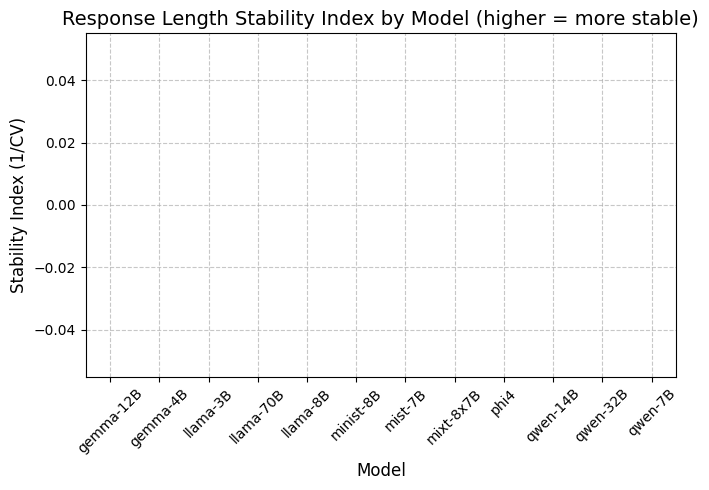

In [44]:
fig = model_stability_index(df, figsize=(7, 5), fontsize=10, rotation=45, grid=True)

In [49]:
def create_dashboard(df, figsize=(18, 24), fontsize=10, rotation=45):
    """
    Create a comprehensive dashboard with multiple visualizations.
    
    Args:
        df: DataFrame containing the LLM response data
        figsize: Tuple specifying figure dimensions (width, height)
        fontsize: Font size for labels
        rotation: Rotation angle for x-tick labels
    
    Returns:
        matplotlib figure
    """
    # set_plot_style()
    
    # Create figure with subplot grid
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(3, 2, figure=fig)
    
    # Add boxplot
    ax1 = fig.add_subplot(gs[0, 0])
    sns.boxplot(
        data=df, 
        x='model', 
        y='output_mean', 
        ax=ax1,
        showfliers = False, # fliersize=3
    )
    ax1.set_title('Response Length by Model', fontsize=fontsize+4)
    ax1.set_xlabel('Model', fontsize=fontsize+2)
    ax1.set_ylabel('Mean Response Length (tokens)', fontsize=fontsize+2)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.tick_params(axis='x', labelsize=fontsize, rotation=rotation)
    
    # Add heatmap
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Calculate coefficient of variation (CV)
    df_cv = df.copy()
    df_cv['cv'] = df['output_std'] / df['output_mean']
    
    # Create pivot table of CV values
    pivot_cv = df_cv.pivot_table(
        values='cv', 
        index='dataset', 
        columns='model', 
        aggfunc='mean'
    )
    
    sns.heatmap(
        pivot_cv, 
        annot=True, 
        cmap='viridis', 
        fmt='.2f',
        linewidths=0.5,
        ax=ax2
    )
    ax2.set_title('Coefficient of Variation by Model and Dataset', fontsize=fontsize+4)
    ax2.set_xlabel('Model', fontsize=fontsize+2)
    ax2.set_ylabel('Dataset', fontsize=fontsize+2)
    ax2.tick_params(axis='x', labelsize=fontsize, rotation=rotation)
    
    # Add scatter plot
    ax3 = fig.add_subplot(gs[1, 0])
    
    # Group data by model
    model_stats = df.groupby('model').agg({
        'output_mean': ['mean', 'std'],
        'output_std': 'mean'
    }).reset_index()
    
    # Flatten multi-level column names
    model_stats.columns = ['model', 'mean_of_means', 'std_of_means', 'mean_std']
    
    ax3.errorbar(
        x=range(len(model_stats)), 
        y=model_stats['mean_of_means'],
        yerr=model_stats['mean_std'],
        fmt='o',
        capsize=5,
        markersize=8,
        elinewidth=2
    )
    ax3.set_title('Mean Response Length with Std Dev', fontsize=fontsize+4)
    ax3.set_xlabel('Model', fontsize=fontsize+2)
    ax3.set_ylabel('Mean Response Length (tokens)', fontsize=fontsize+2)
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.set_xticks(range(len(model_stats)))
    ax3.set_xticklabels(model_stats['model'], fontsize=fontsize, rotation=rotation)
    
    # Add stability index plot
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Calculate coefficient of variation (CV)
    df_stability = df.copy()
    df_stability['cv'] = df['output_std'] / df['output_mean']
    
    # Calculate stability index (inverse of CV)
    df_stability['stability_index'] = 1 / df_stability['cv']
    
    # Group by model and calculate mean stability index
    model_stability = df_stability.groupby('model')['stability_index'].mean().sort_values(ascending=False).reset_index()
    
    sns.barplot(
        data=model_stability,
        x='model',
        y='stability_index',
        ax=ax4
    )
    ax4.set_title('Response Length Stability Index', fontsize=fontsize+4)
    ax4.set_xlabel('Model', fontsize=fontsize+2)
    ax4.set_ylabel('Stability Index (1/CV)', fontsize=fontsize+2)
    ax4.grid(True, linestyle='--', alpha=0.7)
    ax4.tick_params(axis='x', labelsize=fontsize, rotation=rotation)
    
    # Add dataset comparison (violin plot)
    ax5 = fig.add_subplot(gs[2, :])
    
    sns.violinplot(
        data=df, 
        x='dataset', 
        y='output_mean', 
        hue='model',
        split=False,
        inner='quartile', 
        ax=ax5
    )
    ax5.set_title('Response Length by Dataset and Model', fontsize=fontsize+4)
    ax5.set_xlabel('Dataset', fontsize=fontsize+2)
    ax5.set_ylabel('Mean Response Length (tokens)', fontsize=fontsize+2)
    ax5.grid(True, linestyle='--', alpha=0.7)
    ax5.tick_params(axis='x', labelsize=fontsize, rotation=rotation)
    # Move legend outside the plot to avoid overcrowding
    ax5.legend(title='Model', title_fontsize=fontsize, fontsize=fontsize-2, 
              loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    return fig

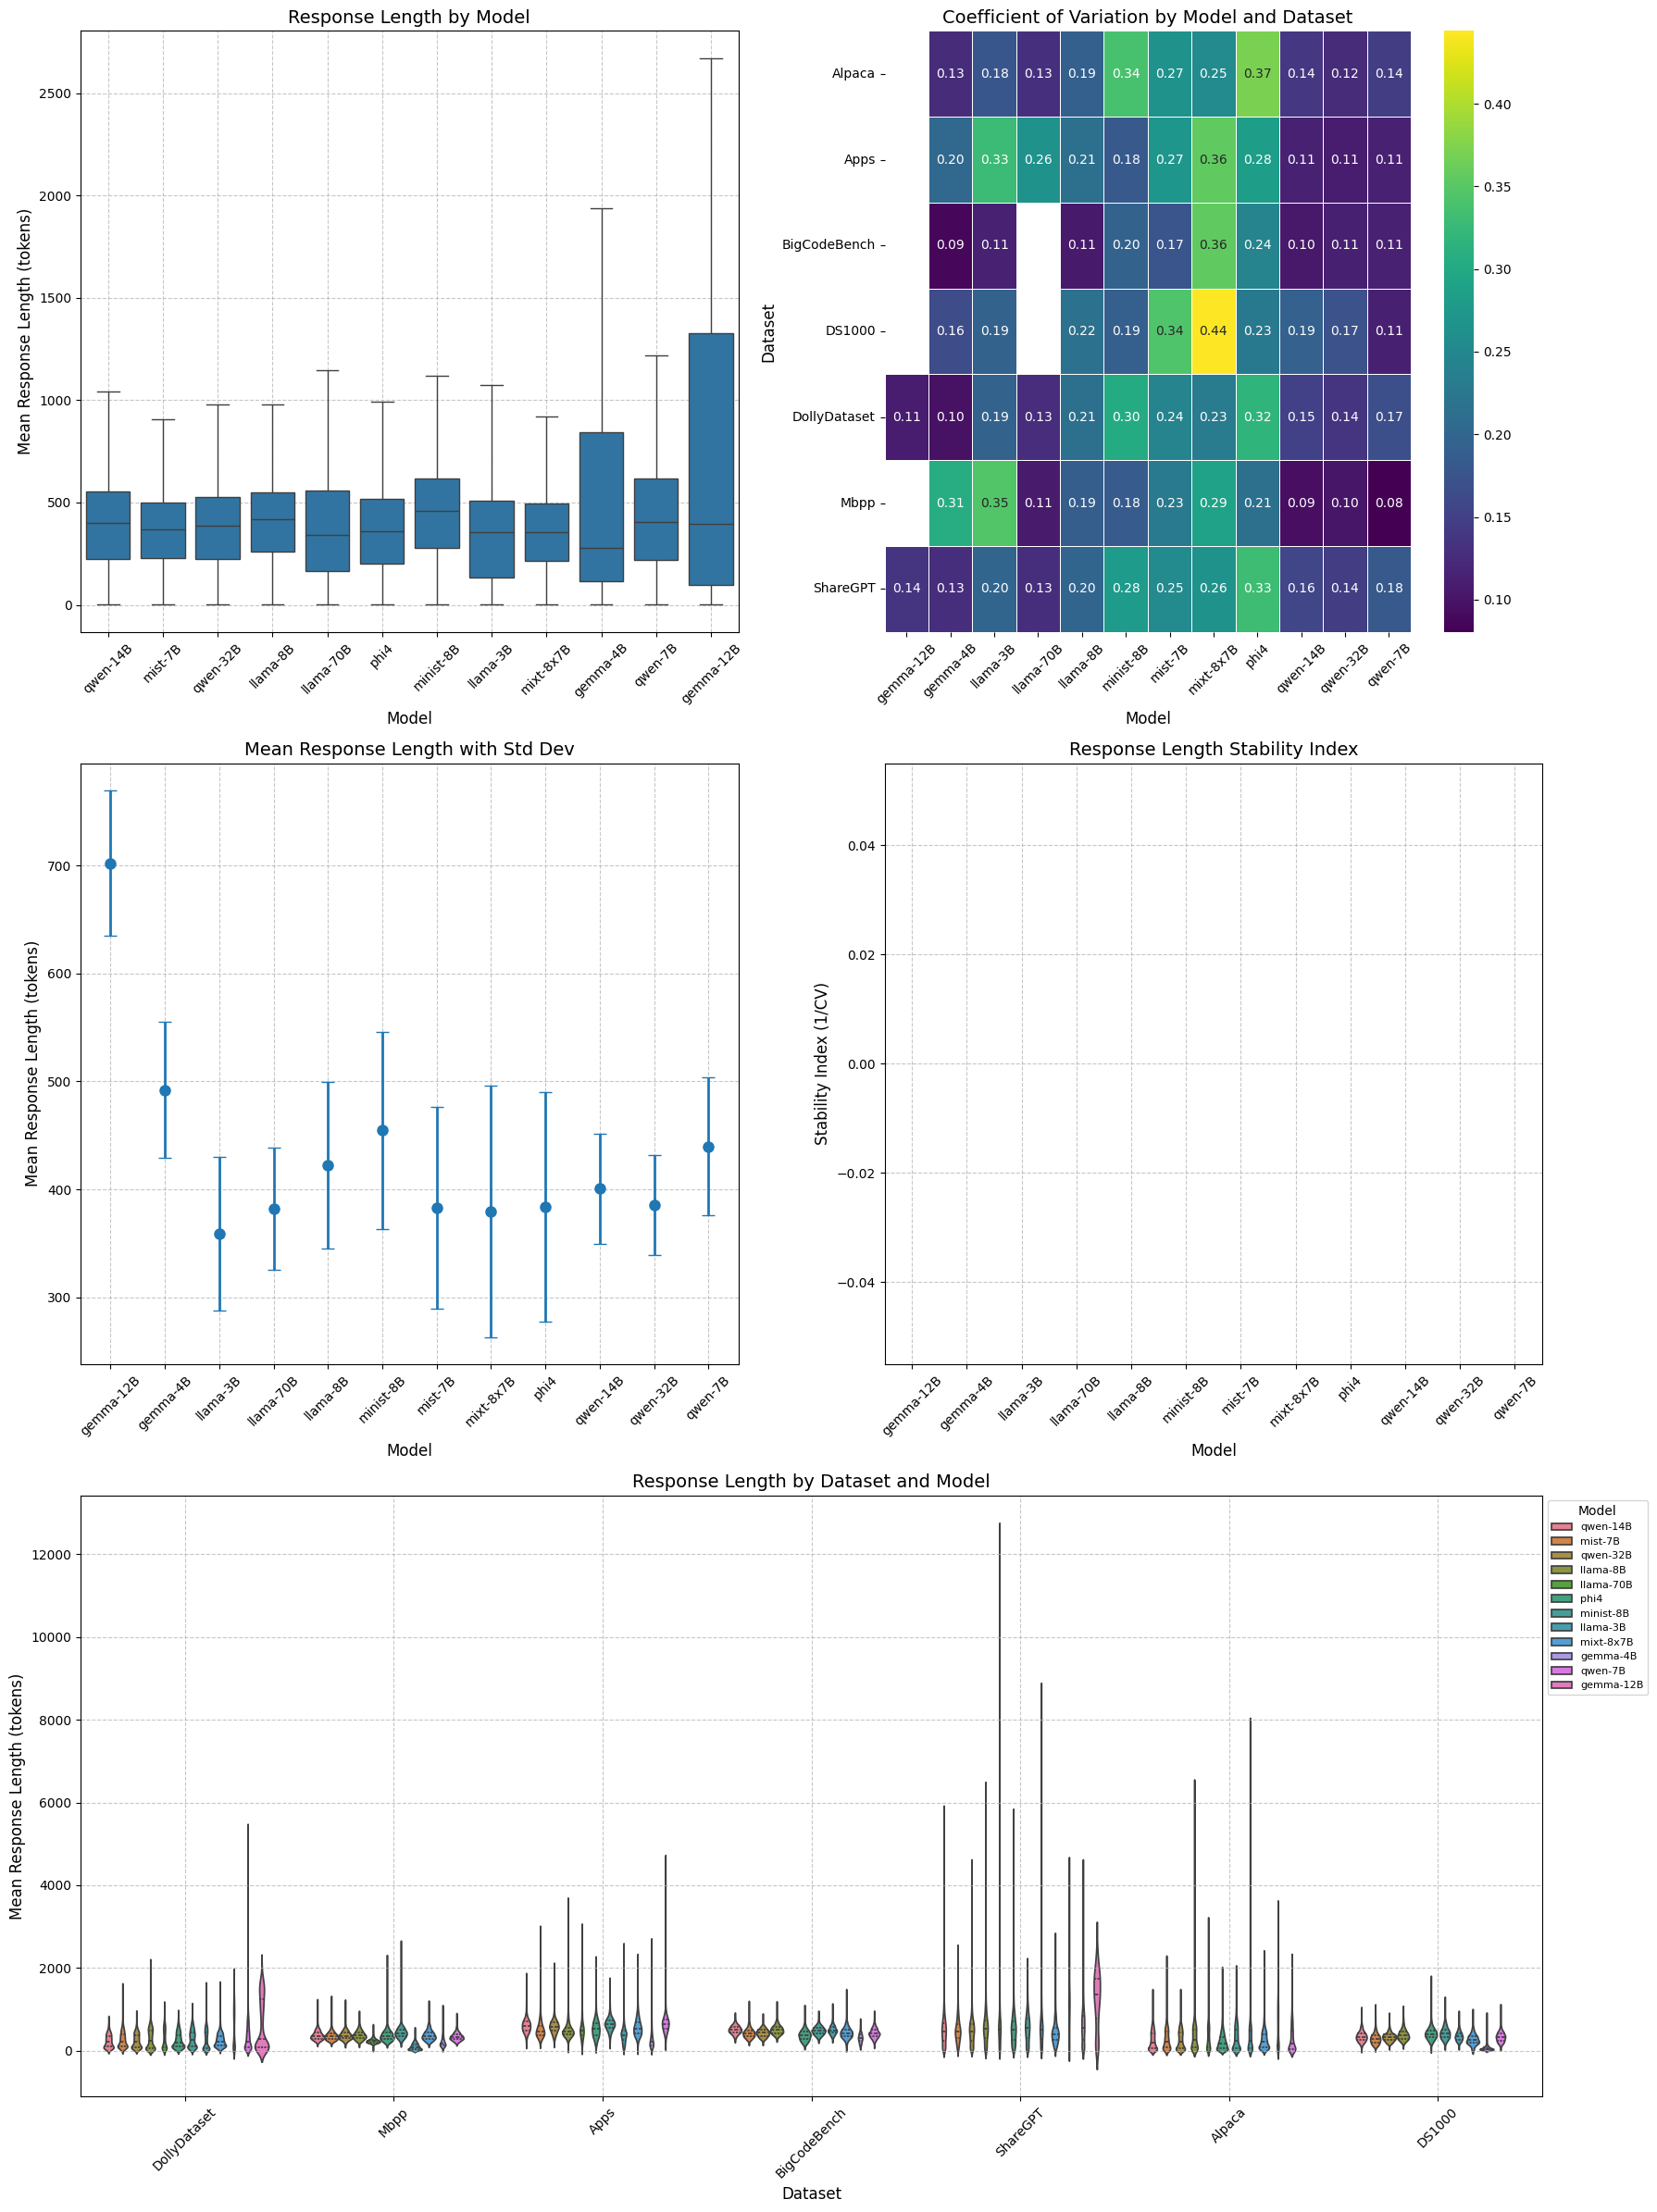

In [50]:
fig = create_dashboard(df, figsize=(18, 24), fontsize=10, rotation=45)

In [16]:
import math

In [22]:
1 - math.exp(-(130000*(130000-1))/(2*math.pow(2, 64)))

4.5807191373370415e-10

In [20]:
(80000**2)/(2*math.pow(2, 64))

1.734723475976807e-10